In [1]:
import sys
import math
import zipfile
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import scipy.signal as ss
import matplotlib.pyplot as plt

from numpy.linalg import lstsq
from google.colab import drive
from matplotlib.lines import Line2D

In [2]:
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/Chapman/Research/RADAR/MLE/classes')

Mounted at /content/drive


In [3]:
import waves

## my code

##### load in libraries

In [4]:
# fit the superfunction with a smaller bandwidth to the sinc
# since we know the sinc has a bandwidth of 10, we can find cosine frequencies
# maxing at half this amount

# Define the Fourier series function using only cosine terms
def fourier_series(t, coefficients, fmin, fmax, make_complex=False):
    result = np.zeros(len(t))
    N = len(coefficients)
    dw = (fmax-fmin)/(N-1)
    if make_complex:
        result = np.zeros(len(t), dtype=np.complex128)
        for k in range(0, N):
            result += coefficients[k] * (np.cos(2*np.pi*t*(fmin+(dw*k))) + 1j*np.sin(2*np.pi*t*(fmin+(dw*k))))
    else:
        for k in range(0, N):
            result += coefficients[k] * np.cos(2*np.pi*t*(fmin+(dw*k)))
    return result

# Construct the design matrix
def get_fourier_fit(t, N, fmin, fmax):
    dw = (fmax-fmin)/(N-1)
    A = np.zeros((len(t), N))
    for k in range(0, N):
        A[:, k] = np.cos(2*np.pi*t*(fmin+(dw*k)))
    return A

# Define the Fourier series function using only cosine terms
def fourier_series_odd(t, coefficients, fmin, fmax, make_complex=False):
    result = np.zeros(len(t))
    N = len(coefficients)
    dw = (fmax-fmin)/(N-1)
    if make_complex:
        result = np.zeros(len(t), dtype=np.complex128)
        for k in range(0, N):
            result += coefficients[k] * (-1j*np.cos(2*np.pi*t*(fmin+(dw*k))) + np.sin(2*np.pi*t*(fmin+(dw*k))))
    else:
        for k in range(0, N):
            result += coefficients[k] * np.sin(2*np.pi*t*(fmin+(dw*k)))
    return result

# Construct the design matrix
def get_fourier_fit_odd(t, N, fmin, fmax):
    dw = (fmax-fmin)/(N-1)
    A = np.zeros((len(t), N))
    for k in range(0, N):
        A[:, k] = np.sin(2*np.pi*t*(fmin+(dw*k)))
    return A

def dlog(wave):
    return np.diff(np.log(wave))

#### creating the wave

##### create sinc to fit to

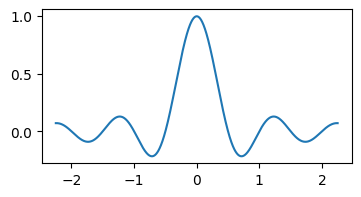

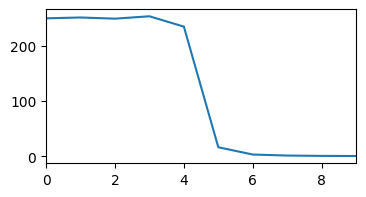

In [ ]:
# create the sinc we will fit to. this sinc clearly has an inverse bandwidth of .1*{window size}

# _sincwidth  = 2
# _sinclength = 1000
_sincwidth  = 4.5
_sinclength = 2250
invbw       = _sinclength/_sincwidth

_t = np.linspace(-_sincwidth/2, _sincwidth/2, _sinclength)
_sinc = np.sin(_t*np.pi*2)/(_t*np.pi*2)
# _sinc = np.cos(_t*np.pi*2)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (4,2)
plt.plot(_t, _sinc)
plt.show()

plt.plot(np.abs(np.fft.fft(_sinc)))
plt.xlim(0,_sincwidth*2)
plt.show()

##### find the best fit

In [ ]:
results = []    # N, Omega, omega_min, max amp, MSE
for N in np.arange(3, 21):
    print('N =', N)
    for freqspread in np.arange(.1, .51, .05):
        print('  freqspread =', round(freqspread,2))
        cyclewidth  = (N-1)/freqspread
        ratio       = cyclewidth/_sincwidth
        for minfreq in np.arange(0, 1-freqspread, .001):
            maxfreq = minfreq + freqspread

            A = get_fourier_fit(_t, N, minfreq, maxfreq)
            coefs, _, _, _ = sp.linalg.lstsq(A, _sinc)

            t_test  = np.linspace(-_sincwidth*ratio/2, _sincwidth*ratio/2, int(_sinclength*ratio))
            t_test2 = np.linspace(-_sincwidth/2, _sincwidth/2, _sinclength)
            y_test  = fourier_series(t_test, coefs, minfreq, maxfreq)
            y_test2 = fourier_series(t_test2, coefs, minfreq, maxfreq)

            # try:
            _max = max(np.abs(y_test))
            # except:
            #     _max = 0
            _mean = np.mean((np.real(_sinc)-np.real(y_test2))**2)
            results.append([N, freqspread, minfreq, _max, _mean])

N = 3
  freqspread = 0.1
  freqspread = 0.15
  freqspread = 0.2
  freqspread = 0.25
  freqspread = 0.3
  freqspread = 0.35
  freqspread = 0.4
  freqspread = 0.45
  freqspread = 0.5
N = 4
  freqspread = 0.1
  freqspread = 0.15
  freqspread = 0.2
  freqspread = 0.25
  freqspread = 0.3
  freqspread = 0.35
  freqspread = 0.4
  freqspread = 0.45
  freqspread = 0.5
N = 5
  freqspread = 0.1
  freqspread = 0.15


KeyboardInterrupt: 

In [ ]:
print(np.shape(results))

np.savetxt('/content/drive/MyDrive/Chapman/Research/RADAR/Reconstructing_Superoscillations/amp_and_MSE_min_results.csv', results, delimiter=',')

##### generate the superfunction

In [ ]:
N           = 6
minfreq     = .4
freqspread  = .25
# N           = 4
# minfreq     = .5
# freqspread  = .25
cyclewidth  = (N-1)/freqspread
cyclelen    = int(cyclewidth * invbw)
maxfreq     = minfreq + freqspread
ratio       = cyclewidth/_sincwidth
realinvbw   = int(invbw/freqspread)

print('N:', N)
print('frequency spread:', freqspread)
print('smallest frequency:', minfreq)
print('cycle width:', cyclewidth)
print('superregion width:', _sincwidth)
print('ratio:', ratio)

A = get_fourier_fit(_t, N, minfreq, maxfreq)
coefs, _, _, _ = sp.linalg.lstsq(A, _sinc)

print('')
print('frequencies:', [np.round(i, 2) for i in np.linspace(minfreq, maxfreq, N)])
print('amplitudes:', [i for i in coefs])
print(_sinclength)

N: 6
frequency spread: 0.25
smallest frequency: 0.4
cycle width: 20.0
superregion width: 4.5
ratio: 4.444444444444445

frequencies: [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
amplitudes: [17.551969178838473, -49.93615200929133, 48.91892825922387, -7.222327926051708, -17.23049063370233, 8.876842152413422]
2250


In [ ]:
# Test the Fourier series
mult    = 1000

t_test  = np.linspace(-(N-1)*mult/2, (N-1)*mult/2, int(cyclelen*mult))
t_test2  = np.linspace(-.5*(9/8), .5*(9/8), _sinclength)
print(len(t_test2))
y_test  = fourier_series(t_test*4, coefs, minfreq, maxfreq, make_complex=True)
y_test2  = fourier_series(t_test2*4, coefs, minfreq, maxfreq, make_complex=True)

print(len(y_test))

2250
10000000


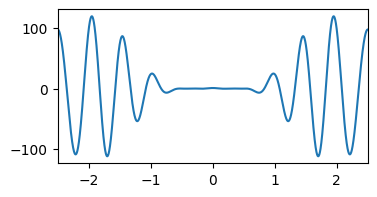

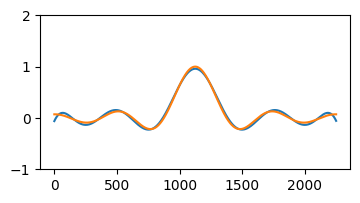

In [ ]:
plt.plot(t_test, np.real(y_test))
plt.xlim(-2.5, 2.5)
plt.show()

plt.plot(np.real(y_test)[10000-int(_sinclength/2):10000+int(_sinclength/2)])
plt.plot(_sinc)
# plt.plot(t_test, np.real(y_test))
# plt.xlim(-.5*9/8, .5*9/8)
plt.ylim(-1, 2)
plt.show()

##### plot and save

###### save it if you want

In [ ]:
# save y_test as 6peaks_10k
# np.savetxt('6peaks_10k2.csv', np.real(y_test))

###### plot it if you want

In [ ]:
# Compute the FFT
dt=1/realinvbw

frequencies     = np.fft.fftfreq(len(y_test), d=dt)
frequencies2    = np.fft.fftfreq(len(y_test2), d=dt)
freq2           = np.fft.fftfreq(len(_sinc), d=dt)

fplot = np.abs(np.fft.fft(np.real(y_test)))
fplot2 = np.abs(np.fft.fft(np.real(y_test2)))
splot = np.abs(np.fft.fft(_sinc))

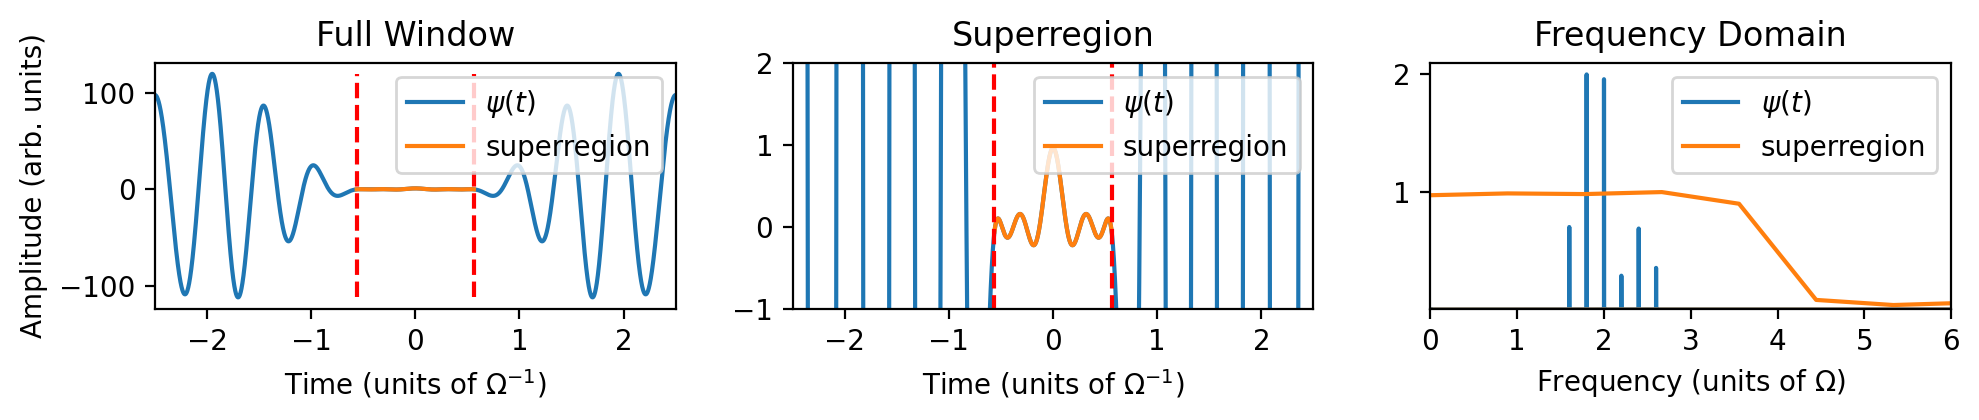

In [ ]:
# why *9/8? because the whloe wave is 10,000 time steps, one inverse bandwidth is 1/5 of that (2000),
# and we fitted to 2250 time steps of the sinc wave. 2250/2000 = 9/8.
# so we fitted to just over one of our inverse bandwidths.
# another way of looking at it: we fitted to 4.5 inverse bandwidths of the sinc, which is four times
# as many inverse bandwidths as the total wave. 4.5/4 = 9/8.

fig, axs = plt.subplots(1, 3, figsize=(10,2.2), dpi=200)

axs[0].plot(t_test, np.real(y_test), label=r'$\psi(t)$')
axs[0].plot(t_test2, np.real(y_test)[10000-int(_sinclength/2):10000+int(_sinclength/2)], label='superregion')
axs[0].vlines([-.5*9/8, .5*9/8], min(np.real(y_test)), max(np.real(y_test)),
              linestyles='dashed', color='r')
axs[0].legend(loc='upper right')
axs[0].set_xlim(-2.5, 2.5)
axs[0].set_xlabel('Time (units of $\Omega^{-1}$)')
axs[0].set_ylabel('Amplitude (arb. units)')
axs[0].set_title('Full Window')

axs[1].plot(t_test, np.real(y_test), label=r'$\psi(t)$')
axs[1].plot(t_test2, np.real(y_test)[10000-int(_sinclength/2):10000+int(_sinclength/2)], label='superregion')
axs[1].vlines([-.5*(9/8), .5*(9/8)], min(np.real(y_test)), max(np.real(y_test)),
              linestyles='dashed', color='r')
axs[1].legend(loc='upper right')
axs[1].set_xlim(-2.5, 2.5)
axs[1].set_ylim(-1,2)
axs[1].set_xlabel('Time (units of $\Omega^{-1}$)')
axs[1].set_title('Superregion')

axs[2].plot(frequencies, fplot*2/np.max(fplot), label=r'$\psi(t)$')
axs[2].plot(frequencies2, fplot2/np.max(fplot2), label='superregion')
# axs[2].plot(frequencies, fplot, label=r'$\psi(t)$')
# axs[2].plot(frequencies2, fplot2, label='superregion')
axs[2].legend(loc='upper right')
axs[2].set_xlim(0,6)
axs[2].set_ylim(.01, 2.1)
axs[2].set_xlabel('Frequency (units of $\Omega$)')
axs[2].set_title('Frequency Domain')

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (6,3)

plt.title('oscillation')
plt.fill_between(t_test[:-1], -.65, -.4, alpha=.2, color='tab:blue')
plt.fill_between(t_test[:-1], .4, .65, alpha=.2, color='tab:blue')
plt.fill_between(t_test[:-1], -.4, .4, alpha=.1, color='tab:gray')
plt.hlines((-.65, -.4, .4, .65), -2.5, 2.5, linestyles='dashed', color='black')
plt.vlines([-.5*(9/8), .5*(9/8)], min(np.real(y_test)), max(np.real(y_test)),
              linestyles='dashed', color='r')
plt.plot(t_test[:-1], np.diff(np.unwrap(np.angle(y_test)))*invbw/(2*np.pi), color='tab:blue')
plt.xlim(-2.5, 2.5)
plt.ylim(-3, 1)
plt.show()

plt.title('growth')
plt.fill_between(t_test[:-1], -.65, -.4, alpha=.2, color='tab:blue')
plt.fill_between(t_test[:-1], .4, .65, alpha=.2, color='tab:blue')
plt.fill_between(t_test[:-1], -.4, .4, alpha=.1, color='tab:gray')
plt.hlines((-.65, -.4, .4, .65), -2.5, 2.5, linestyles='dashed', color='black')
plt.vlines([-.5*(9/8), .5*(9/8)], min(np.real(y_test)), max(np.real(y_test)),
              linestyles='dashed', color='r')
plt.plot(t_test[:-1], np.diff(np.abs(y_test))*invbw/(np.abs(y_test)[:-1]*2*np.pi), color='tab:blue')
plt.xlim(-2.5, 2.5)
plt.ylim(-2, 2)
plt.show()

##### add noise and print some power values

In [ ]:
# snr     = 1e0
# noisesd = np.sqrt(np.var(np.real(y_test))/snr)
noisesd = 300
signal  = np.real(y_test) + np.random.normal(0, noisesd, len(y_test))
sc_fft  = np.fft.fft(signal)

print('signal sd:', np.std(signal))
print('noise sd:', noisesd)
print('snr:', (np.std(signal)/noisesd)**2)
print('superregion sd:', np.std(y_test2))
print('superregion snr:', np.std(y_test2)/noisesd)
print('superregion snr by max:', (max(np.real(y_test2))-min(np.real(y_test2)))/noisesd)

In [ ]:
windowlen = int((mult*_sincwidth*maxfreq) * 1.5)

fig, axs = plt.subplots(1, 2, figsize=(8,2), dpi=100)

axs[0].plot(signal)
axs[0].set_xlim(int(cyclelen/2),cyclelen+int(cyclelen/2))
axs[0].set_title('full cycle')

axs[1].plot(np.abs(sc_fft))
axs[1].set_xlim(0,30000)
axs[1].set_yscale('log')
axs[1].set_ylim(1e4,1e13)
axs[1].set_title('FFT')

plt.show()

#### filtering and tests

##### find the peaks

In [ ]:
# signal = np.real(y_test)

spread          = 0
windowlen       = int((mult*_sincwidth*maxfreq + spread) * 1.5)

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (4,2)
plt.plot(np.abs(sc_fft))
plt.xlim(0,windowlen)
plt.yscale('log')
plt.ylim(1e1, 1e10)
plt.show()

peaks, vals     = ss.find_peaks(np.abs(sc_fft[:windowlen+5]), height=1e0)
peaks2, vals2   = ss.find_peaks(np.abs(sc_fft[-windowlen-5:]), height=1e0)
peaks2         -= windowlen+5
peaks           = np.sort(peaks[np.argsort(vals['peak_heights'])[::-1]][:N])
peaks2          = np.sort(peaks2[np.argsort(vals2['peak_heights'])[::-1]][:N])

print('frequency locations:', peaks, peaks2)
print('bandwidth: ', peaks[-1]-peaks[0])
print('time steps:', len(sc_fft))
print('# time steps per inverse bandwidth:', len(sc_fft)/(peaks[-1]-peaks[0]))
print(2*peaks*(peaks[-1]-peaks[0])/len(sc_fft))

##### spectral filtering and plotting results

In [ ]:
sc_fft[peaks[-1]+1+spread:peaks2[0]-spread]  = 0
sc_fft[:peaks[0]] = 0
sc_fft[peaks2[-1]+1:] = 0

for i in range(len(peaks)-1):
    start = peaks[i]+spread+1
    end = peaks[i+1]-spread
    sc_fft[start:end] = 0

for i in range(len(peaks2)-1):
    start = peaks2[i]+spread+1
    end = peaks2[i+1]-spread
    sc_fft[start:end] = 0

sc_ifft = np.fft.ifft(sc_fft)

fig, axs = plt.subplots(1, 3, figsize=(12,2.5), dpi=100)

axs[0].plot(t_test, signal, label='unfiltered')
axs[0].plot(t_test, np.real(y_test), label='original', c='tab:orange')
axs[0].plot(t_test, np.real(sc_ifft), label='filtered', c='gold')
axs[0].legend(loc='upper right')
axs[0].set_xlim(-cyclewidth/2,cyclewidth/2)

axs[1].plot(t_test, signal, label='unfiltered')
axs[1].plot(t_test, np.real(y_test), label='original', c='tab:orange')
axs[1].plot(t_test, np.real(sc_ifft), label='filtered', c='gold')
axs[1].legend(loc='upper right')
axs[1].set_xlim(-_sincwidth,_sincwidth)
axs[1].set_ylim(-noisesd*4, noisesd*4)

axs[2].plot(t_test, signal, label='unfiltered')
axs[2].plot(t_test, np.real(y_test), label='original', c='tab:orange')
axs[2].plot(t_test, np.real(sc_ifft), label='filtered', c='gold')
axs[2].legend(loc='upper right')
axs[2].set_xlim(-_sincwidth,_sincwidth)
axs[2].set_ylim(-1, 2)

plt.tight_layout()
plt.show()

##### iterative statistical test

In [ ]:
mses = []

for i in range(100):
    if i%10 == 0:
        print(i)

    noisesd = 10
    signal  = np.real(y_test) + np.random.normal(0, noisesd, len(y_test))
    sc_fft  = np.fft.fft(signal)

    peaks, vals     = ss.find_peaks(np.abs(sc_fft[:windowlen+5]), height=1e0)
    peaks2, vals2   = ss.find_peaks(np.abs(sc_fft[-windowlen-5:]), height=1e0)
    peaks2         -= windowlen+5
    peaks           = np.sort(peaks[np.argsort(vals['peak_heights'])[::-1]][:N])
    peaks2          = np.sort(peaks2[np.argsort(vals2['peak_heights'])[::-1]][:N])

    sc_fft[peaks[-1]+1+spread:peaks2[0]-spread]  = 0
    sc_fft[:peaks[0]] = 0
    sc_fft[peaks2[-1]+1:] = 0

    for i in range(len(peaks)-1):
        start = peaks[i]+spread+1
        end = peaks[i+1]-spread
        sc_fft[start:end] = 0

    for i in range(len(peaks2)-1):
        start = peaks2[i]+spread+1
        end = peaks2[i+1]-spread
        sc_fft[start:end] = 0

    sc_ifft = np.fft.ifft(sc_fft)
    _cyclelen = int(len(y_test)/10)

    mses.append(np.std(np.real(sc_ifft[_cyclelen-2250:_cyclelen+2250])-
             np.real(y_test[_cyclelen-2250:_cyclelen+2250])))

In [ ]:
print('mean:', np.mean(mses))
print('var:', np.var(mses))

In [ ]:
# np.savetxt('7peaks_40000.csv', np.real(y_test))

## import and process lab data

### iterative test

In [ ]:
# get ready to store all the waves in a big array
'''
just changed this in two meaningful ways:
  - only processing the real portion of the fft should make the iffts all phase-aligned
  - removing all negative frequencies makes the ifft a complex wave, so we can use all
    the benefits of superoscillation and supergrowth analysis
'''
def get_reconstructions(arr, count, cyclen, N, numcycles, printpeaks=True):
    wavesarr    = [np.zeros(cyclen, dtype=np.complex128) for i in range(count)]
    for i in range(count):
        # pick the next cycle in the series
        cycle   = arr[i*cyclen*numcycles:(i+1)*cyclen*numcycles]
        sc_fft  = np.fft.fft(cycle)

        # helps zero out troublesome low frequencies that sometimes have too large of amplitudes
        sc_fft[:7] = 0
        # sc_fft[-7:] = 0

        # find locations of target frequencies. this assumes each frequency is not drowned in noise
        peaks   = np.sort(np.argsort(np.abs(sc_fft))[-N*2:])[:N]
        if (i%10 == 0) and (printpeaks):
            print(peaks)

        # # filter out frequencies we know we don't need
        # for j in range(len(sc_fft)):
        #     if j not in peaks:
        #         sc_fft[j] = 0

        mask = np.zeros_like(sc_fft, dtype=bool)
        mask[peaks] = True

        # Zero out elements not in peaks
        sc_fft[~mask] = 0

        # return the signal to time domain and save in the 2D array
        wavesarr[i] = np.real(np.fft.ifft(sc_fft))
    return wavesarr

In [ ]:
# process 100 different cycles by spectrally filtering each individually
# and store them in a new 2D array

# variable dump
_sinclength = 2250
_sincwidth  = 4.5
N           = 6
filelen     = 10000000
cyclelen    = 10000
cyclewidth  = 20
superstart  = int(cyclelen/2)-int(_sinclength/2)
spread      = int(_sinclength/2)

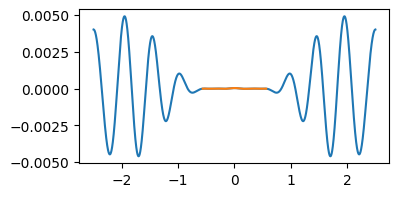

In [ ]:
# simulated wave to compare lab results to

cntr            = int(cyclelen/2)
sim_one_cycle   = np.copy(np.real(y_test[int(cyclelen/2):cyclelen+int(cyclelen/2)]))/24300
sim_one_cycle  -= np.mean(sim_one_cycle)
sim_super       = sim_one_cycle[cntr-spread:cntr+spread]
sim_super      -= np.mean(sim_super)
t_one_cycle     = np.linspace(-2.5, 2.5, cyclelen)

plt.plot(t_one_cycle, sim_one_cycle)
plt.plot(t_test2, sim_super)
plt.show()

In [ ]:
# get the data from the file. maybe we make this iterative for tests

filepath    = '/content/drive/MyDrive/Chapman/Research/RADAR/Derek/Reconstructing_Superoscillations/6peaks/400kHz/'
filed       = pd.read_csv(filepath+'6_10mV_8mV_30ft.csv')

In [ ]:
start       = 10
data        = np.array(filed['CH1V'])[start:start+filelen]
wavecount   = 10
mid         = int(cyclelen/2)
numcycles   = 10

In [ ]:
fullarr   = get_reconstructions(data, wavecount, cyclelen, N, numcycles)
superarr  = [fullarr[i][mid-spread:mid+spread] for i in range(wavecount)]
for i in range(wavecount):
    fullarr[i] -= np.mean(superarr[i])

[ 80  90 100 110 120 130]


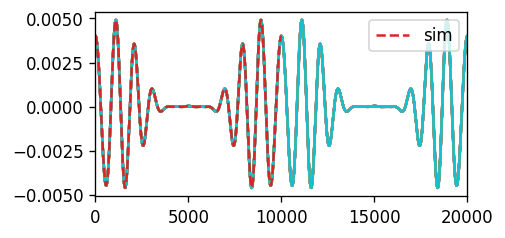

In [ ]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (4,2)
for i in range(10):
    plt.plot(2*fullarr[i])
plt.plot(sim_one_cycle, color='tab:red', label='sim', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlim(0, 20000)
# plt.ylim(-.00002, .00004)
plt.show()

In [ ]:
# 1163
_0ft        = fullarr
super_0ft   = superarr

In [ ]:
# 1110
_10ft       = fullarr
super_10ft  = superarr

In [ ]:
# 1110
_20ft       = fullarr
super_20ft  = superarr

In [ ]:
# 10
_30ft       = fullarr
super_30ft  = superarr

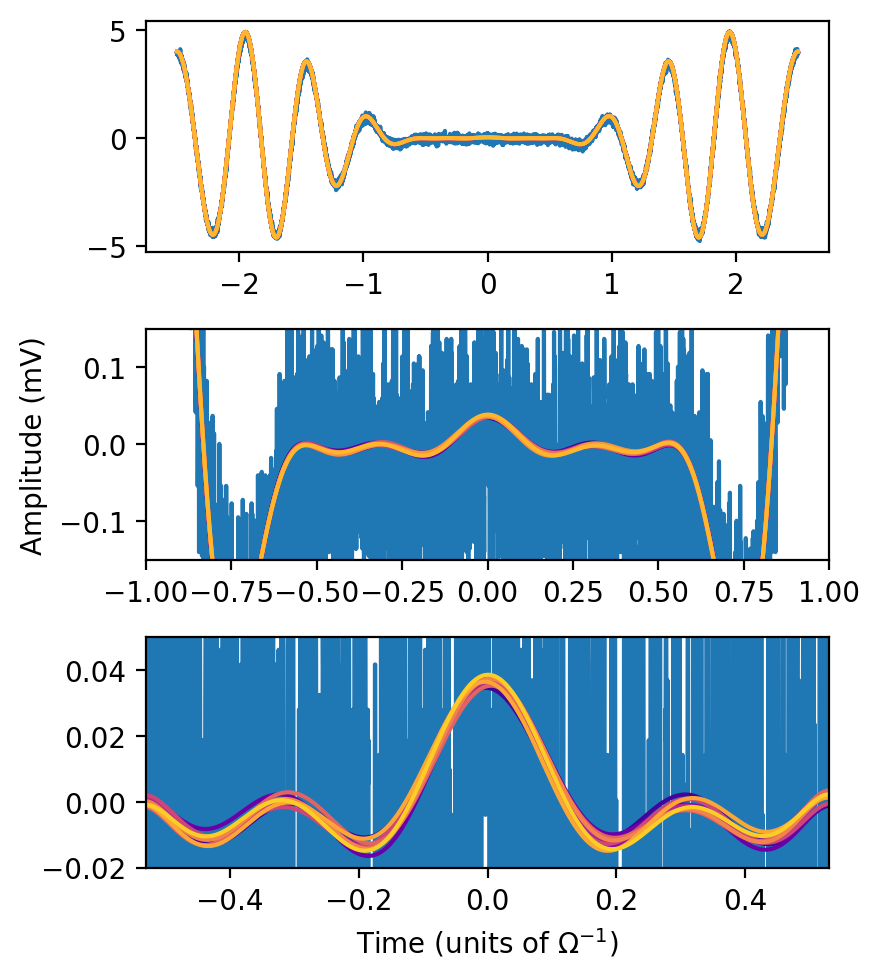

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(4.5,5), dpi=200)

for i in range(3):
    axs[i].plot(t_one_cycle, data[:cyclelen]*1050+.08)
    # axs[i].legend(loc='upper right')

for i in range(len(_0ft)):
    axs[0].plot(t_one_cycle, _0ft[i][:cyclelen]*2000, color=mpl.cm.plasma(i/(wavecount*1.07)))
    axs[1].plot(t_one_cycle, _0ft[i][:cyclelen]*2000, color=mpl.cm.plasma(i/(wavecount*1.07)))
    axs[2].plot(t_one_cycle, _0ft[i][:cyclelen]*2000, color=mpl.cm.plasma(i/wavecount))

axs[1].set_xlim(-1, 1)
axs[1].set_ylim(-.15, .15)
axs[1].set_ylabel('Amplitude (mV)')

axs[2].set_xlim(-.53, .53)
axs[2].set_ylim(-.02, .05)
axs[2].set_xlabel('Time (units of $\Omega^{-1}$)')

plt.tight_layout()
plt.show()

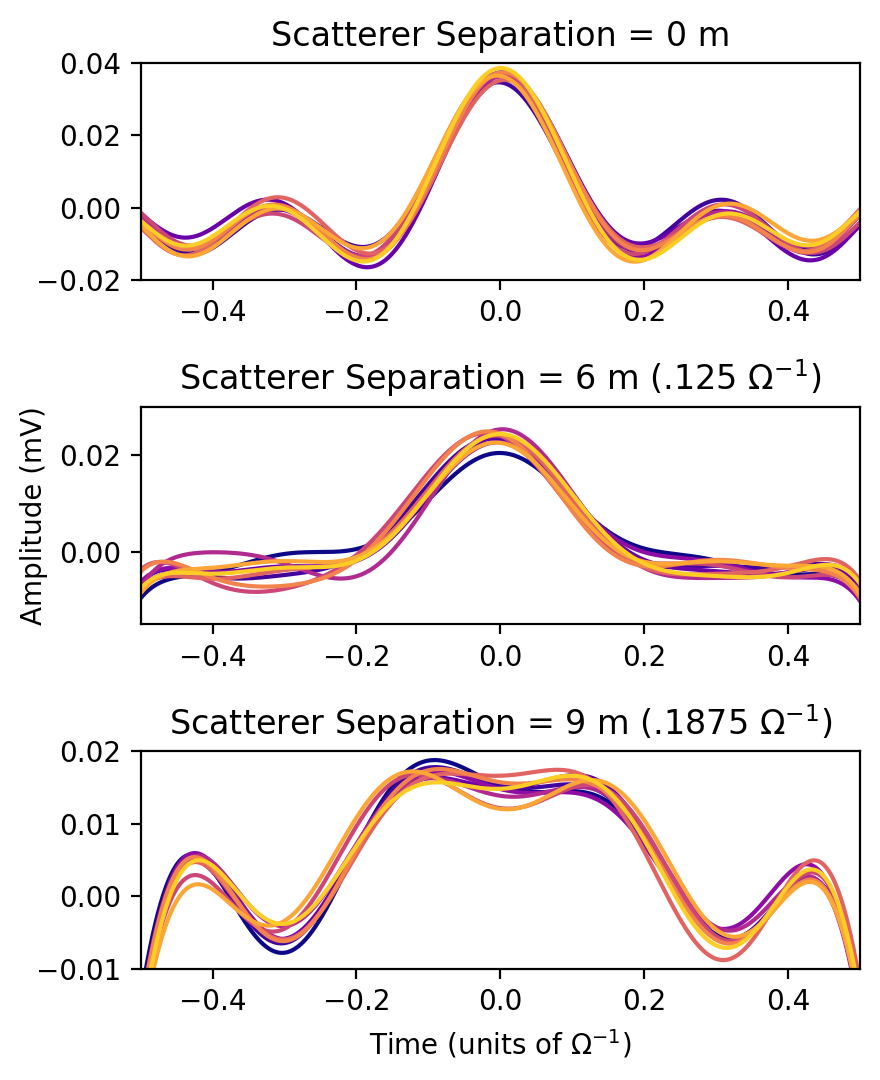

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(4.5,5.5), dpi=200)

newmod = .01
import matplotlib as mpl
k = 0

for i in [_0ft, _20ft, _30ft]:
    # axs[k].plot(t_one_cycle, data[:cyclelen]*1000)
    for j in range(wavecount):
        axs[k].plot(t_one_cycle, i[j][:cyclelen]*2000, color=mpl.cm.plasma(j/wavecount))
        # axs[k].plot(t_one_cycle, i[j][:cyclelen]*1000)
        axs[k].set_xlim(-.5, .5)
        axs[k].set_ylim((-2+.5*k)*newmod, (4-k)*newmod)
    k += 1
axs[2].set_xlabel('Time (units of $\Omega^{-1}$)')
axs[1].set_ylabel('Amplitude (mV)')
axs[0].set_title('Scatterer Separation = 0 m')
axs[1].set_title(r'Scatterer Separation = 6 m (.125 $\Omega^{-1}$)')
axs[2].set_title(r'Scatterer Separation = 9 m (.1875 $\Omega^{-1}$)')
plt.tight_layout()
plt.show()

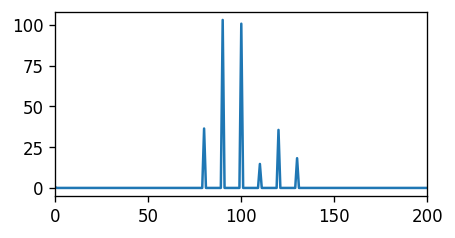

In [ ]:
plt.plot(np.abs(np.fft.fft(fullarr[0])))
plt.xlim(0,200)
plt.show()

#### calculate RMSEs

In [ ]:
wavemean    = np.mean(fullarr, axis=0)
supermean   = np.mean(superarr, axis=0)
errs        = []
superrs     = []

for i in range(wavecount):
    err     = np.var(fullarr[i]-wavemean)
    superr  = np.var(superarr[i]-supermean)
    errs.append(err)
    superrs.append(superr)

In [ ]:
print('total wave normalized MSE:', np.mean(errs)/np.var(wavemean))
print('superregion normalized MSE:', np.mean(superrs)/np.var(supermean))

print('total wave normalized RMSE:', np.sqrt(np.mean(errs)/np.var(wavemean)))
print('superregion normalized RMSE:', np.sqrt(np.mean(superrs)/np.var(supermean)))

print('total wave MSE:', np.mean(errs))
print('superregion MSE:', np.mean(superrs))

print('total wave RMSE:', np.sqrt(np.mean(errs)))
print('superregion RMSE:', np.sqrt(np.mean(superrs)))

total wave normalized MSE: 5.163994372636325e-07
superregion normalized MSE: 0.011914561042245829
total wave normalized RMSE: 0.0007186093773835911
superregion normalized RMSE: 0.10915384117036757
total wave MSE: 2.4632142191556806e-12
superregion MSE: 2.1406289119240643e-12
total wave RMSE: 1.569463035294454e-06
superregion RMSE: 1.4630888257122546e-06


#### find zero-crossings and calculate mean and std

In [ ]:
def get_widths(arr, count, start, stop, mod):
    zerosarr = [arr[i][start:stop]+mod for i in range(count)]
    zeros = []
    for i in range(count):
        zero_crossings = np.where(np.diff(np.sign(zerosarr[i])))[0]
        zeros.append(zero_crossings)

    widths = np.zeros(count)
    for i in range(count):
        widths[i] = np.mean(zeros[i][-1]-zeros[i][0])

    return np.mean(widths)/4000, np.std(widths)/4000


def get_widths_by_extrema(arr, count, start, stop, mod=0):
    zerosarr = [arr[i][start:stop]+mod for i in range(count)]
    # similar to the above function, but instead of finding the zero crossings, find the outermost minima/maxima
    extrema = []
    for i in range(count):
        ext = ss.argrelextrema(np.abs(zerosarr[i]), np.greater, order=400)
        extrema.append(ext[0])

    widths = np.zeros(count)
    for i in range(count):
        widths[i] = np.mean(extrema[i][-1]-extrema[i][0])

    return np.mean(widths)/4000, np.std(widths)/4000

In [ ]:
_0ft_mean, _0ft_std = get_widths_by_extrema(wavesarr, wavecount, 7000, 13000)
# _0ft_mean, _0ft_std = get_widths(wavesarr, wavecount, 7000, 13000, .0001)
print(_0ft_mean, _0ft_std)

In [ ]:
onewave = wavesarr[0][0:20000]

plt.plot(onewave)
plt.show()

print(ss.argrelextrema(np.abs(onewave), np.greater, order=400))

NameError: name 'wavesarr' is not defined

##### put it all together for an iterative test
where is the ideal spot to look for zero-crossings, based on the change in location divided by the uncertainty in location?

In [ ]:
# filelen     = 8000000
# cyclelen    = 20000
# filepath    = '/content/drive/MyDrive/Chapman/Research/3Dmapping/MLE/ghost_waves/6peaks/20kHz/'
# t_test      = np.linspace(-cyclewidth/2, cyclewidth/2, cyclelen)
# # starts      = [2250, 2200, 17775, 2250]
# starts      = [2250, 2250]
# thebiggie   = []
# wavecount   = 100

# filed       = pd.read_csv(filepath+'20kHz_10mV_0ft0.csv')
# data        = np.array(filed['CH1V'])[starts[i]:starts[i]+filelen]
# data       -= np.mean(data)
# wavesarr1   = get_reconstructions(data, wavecount, cyclelen, N, 2, printpeaks=False)

# filed       = pd.read_csv(filepath+'20kHz_10mV_30ft0.csv')
# data        = np.array(filed['CH1V'])[starts[i]:starts[i]+filelen]
# data       -= np.mean(data)
# wavesarr2   = get_reconstructions(data, wavecount, cyclelen, N, 2, printpeaks=False)

# for mod in np.arange(-.001, .002, .00025):
thebiggie = []
mod     = 0
for spread in range(2500, 8600, 1000):
    s_start = 10000 - spread
    s_end   = 10000 + spread
    i       = 0
    results = []
    for wavesarr in [wavesarr1, wavesarr2]:
        try:
            # tempwidths = get_widths(wavesarr, wavecount, s_start, s_end, mod)
            tempwidths = get_widths_by_extrema(wavesarr, wavecount, s_start, s_end, mod)
            results.append(tempwidths)
        except:
            continue
        i += 1

    results     = np.array(results)
    try:
        locations   = results[:,0]
        error       = np.mean(results[:,1])
        finals      = [locations[0]-locations[-1], error, (locations[0]-locations[1])/error]
        print(-round(mod,5), round(10000-(locations[0]*2000),3), np.abs(finals[-1]))
        thebiggie.append([-round(mod,4), 10000-(locations[0]*2000), np.abs(finals[-1])])
    except:
        continue

0 8966.06 0.4132242058823813
0 7014.735 28.45712439609631
0 6080.68 37.935631579813666
0 5129.085 29.66000865390486
0 4166.455 20.733829599194472
0 3191.165 9.175724146761597
0 2194.37 5.566017314963774


In [ ]:
print(np.shape(thebiggie))
for i in thebiggie:
    print(i)

(7, 3)
[0, 8966.06, 0.4132242058823813]
[0, 7014.735000000001, 28.45712439609631]
[0, 6080.68, 37.935631579813666]
[0, 5129.085, 29.66000865390486]
[0, 4166.455, 20.733829599194472]
[0, 3191.165, 9.175724146761597]
[0, 2194.37, 5.566017314963774]


In [ ]:
# save to a csv file
np.savetxt('results2.csv', thebiggie, delimiter=',')

In [ ]:
# load the file and replace thewholeshebang
allstuff = np.loadtxt('results.csv', delimiter=',')

# sort by the value of the final index in each row, in decreasing order
allstuff = allstuff[np.argsort(allstuff[:,-1])[:-2]]

print(np.shape(allstuff))

(174, 3)


In [ ]:
allstuff = np.concatenate((allstuff, thebiggie))
print(np.shape(allstuff))

(181, 3)


In [ ]:
print(allstuff)

[[ 2.00000000e-04  2.69038000e+03  7.44444562e-01]
 [ 2.00000000e-04  2.69038000e+03  7.44444562e-01]
 [-6.00000000e-04  3.66098000e+03  9.76173566e-01]
 [-6.00000000e-04  3.66098000e+03  9.76173566e-01]
 [ 8.00000000e-04  4.61098000e+03  1.05601878e+00]
 [ 8.00000000e-04  4.61098000e+03  1.05601878e+00]
 [-7.00000000e-04  3.65342000e+03  1.65228097e+00]
 [-7.00000000e-04  3.65342000e+03  1.65228097e+00]
 [ 1.00000000e-04  2.69695500e+03  1.69399906e+00]
 [ 1.00000000e-04  2.69695500e+03  1.69399906e+00]
 [-7.00000000e-04  5.54789000e+03  1.71646525e+00]
 [-7.00000000e-04  5.54789000e+03  1.71646525e+00]
 [ 9.00000000e-04  4.60044500e+03  2.08026335e+00]
 [ 9.00000000e-04  4.60044500e+03  2.08026335e+00]
 [-0.00000000e+00  7.81385000e+03  2.79093280e+00]
 [ 3.00000000e-04  2.68375000e+03  3.30587274e+00]
 [ 3.00000000e-04  2.68375000e+03  3.30587274e+00]
 [-8.00000000e-04  5.52951000e+03  3.32657753e+00]
 [-8.00000000e-04  5.52951000e+03  3.32657753e+00]
 [-5.00000000e-04  3.66850000e+

<ipython-input-89-33bef3e062f2>:5: RuntimeWarning: invalid value encountered in power
  colors = np.log(allstuff[:,2]*2)**(.3)


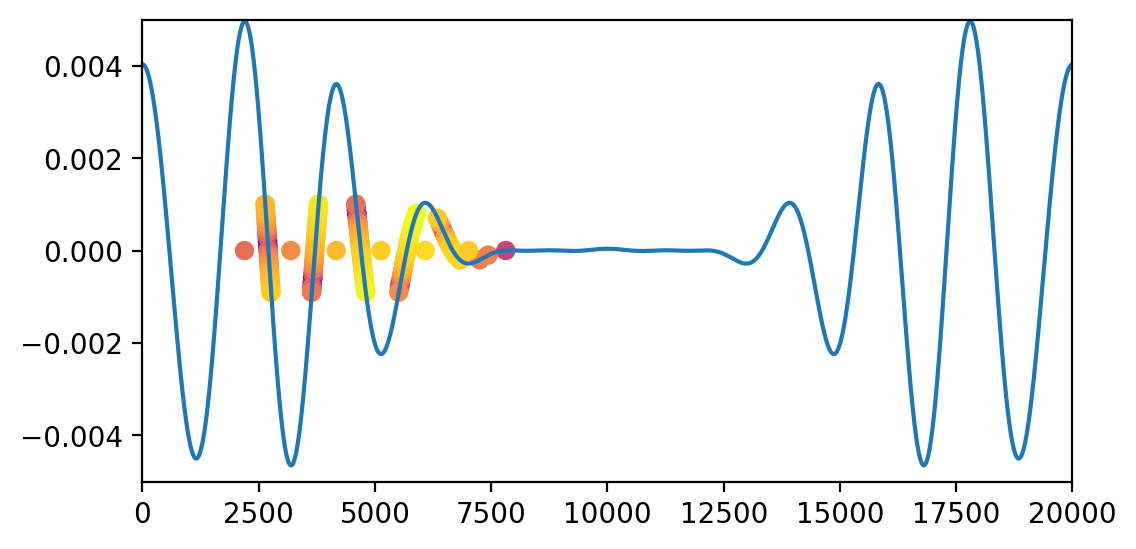

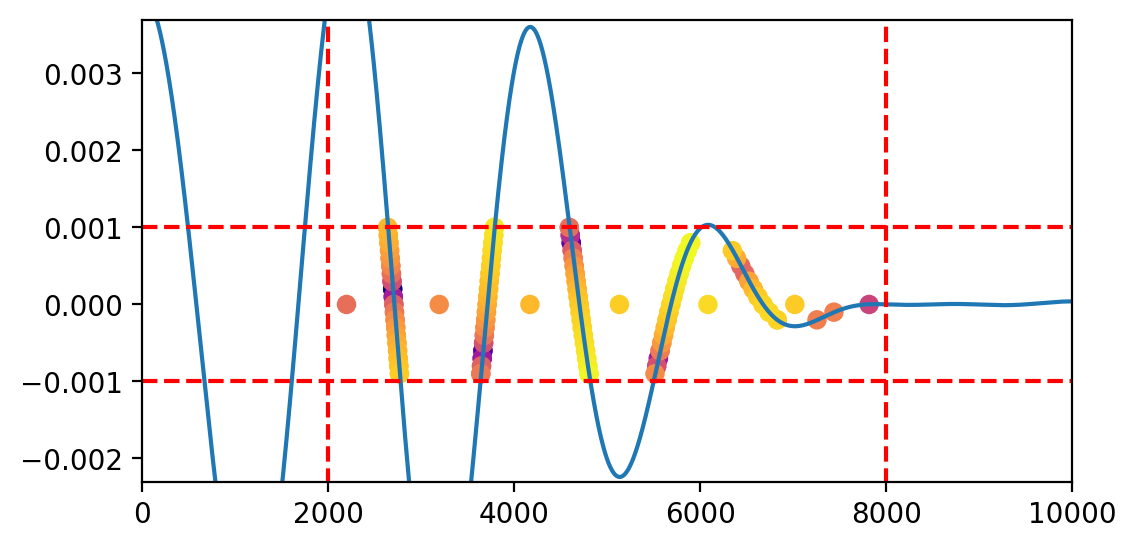

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (6,3)

# allstuff = np.loadtxt('results.csv', delimiter=',')
colors = np.log(allstuff[:,2]*2)**(.3)
plt.scatter(allstuff[:,1], allstuff[:,0], c=colors, cmap='plasma')
plt.plot(sim_one_cycle)
plt.xlim(0000, 20000)
plt.ylim(-.005, .005)
plt.show()

plt.scatter(allstuff[:,1], allstuff[:,0], c=colors, cmap='plasma')
plt.plot(sim_one_cycle)
plt.vlines([2000, 8000], -.005, .005, linestyles='dashed', color='r')
plt.hlines([-.001, .001], 0, 10000, linestyles='dashed', color='r')
plt.xlim(0, 10000)
plt.ylim(-.0023, .0037)
plt.show()

In [ ]:
results     = np.array(results)
locations   = results[:,0]
error       = np.mean(results[:,1], axis=0)
print('locations:', locations)
print('error:', error)

locations: [1.282435  1.2811625 1.274775  1.263995 ]
error: 0.0025145916451926546


### single test

In [ ]:
filepath = '/content/drive/MyDrive/Chapman/Research/3Dmapping/MLE/ghost_waves/6peaks/20kHz/'
# filepath = '100k_10V_8V_20ft0.csv'
# filepath = 'clean0.csv'

In [ ]:
_sinclength = 2250
_sincwidth  = 4.5
N           = 6
start       = 0
# filelen     = 8000000
filelen     = 10000000
cyclelen    = 10000
superstart  = int(cyclelen/2)-int(_sinclength/2)

filed       = pd.read_csv(filepath+'20kHz_10mV_30ft0.csv')
# filed       = pd.read_csv(filepath)

data        = np.array(filed['CH1V'])[start:start+filelen]
data       -= np.mean(data)
sc_fft      = np.fft.fft(data)

sim_one_cycle   = np.copy(np.real(y_test[int(cyclelen/2):cyclelen+int(cyclelen/2)]))/24100
sim_one_cycle  -= np.mean(sim_one_cycle)
sim_super       = sim_one_cycle[7750:12250] - np.mean(sim_one_cycle[7750:12250])

##### plots and SNR values

signal power: 4.853568979172939e-06
superregion power: 8.276798721180731e-09
simulated signal power: 4.811998219485599e-06
simulated superregion power: 1.64604196761042e-10
SNR: 115.75439697704216
superregion SNR: 0.02029095780008025


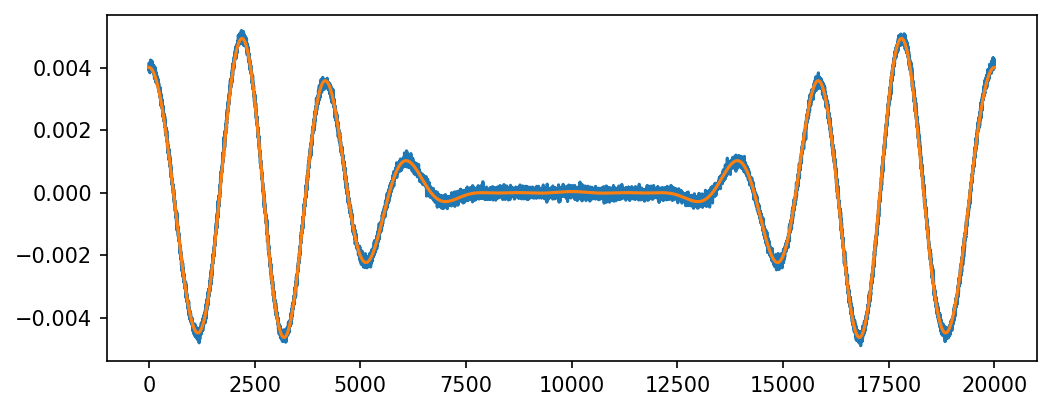

In [ ]:
data_one_cycle  = np.copy(np.real(data[:cyclelen]))
data_one_cycle -= np.mean(data_one_cycle)
data_super      = data_one_cycle[7750:12250] - np.mean(data_one_cycle[7750:12250])

signal_var      = np.var(data_one_cycle)
super_var       = np.var(data_super)
sim_var         = np.var(sim_one_cycle)
sim_super_var   = np.var(sim_super)
signal_noise    = signal_var - sim_var
super_noise     = super_var - sim_super_var

print('signal power:', signal_var)
print('superregion power:', super_var)
print('simulated signal power:', sim_var)
print('simulated superregion power:', sim_super_var)
print('SNR:', sim_var/(signal_noise))
print('superregion SNR:', sim_super_var/(super_noise))

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (8,3)

plt.plot(data_one_cycle)
plt.plot(sim_one_cycle)
plt.show()

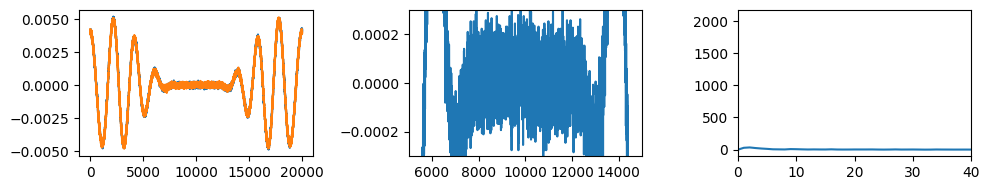

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,2), dpi=100)

axs[0].plot(data[:cyclelen])
axs[0].plot(data[cyclelen*10:cyclelen*11])

axs[1].plot(data[:cyclelen])
axs[1].set_ylim(-.0003, .0003)
axs[1].set_xlim(5000, 15000)

axs[2].plot(np.abs(np.fft.fft(data)))
# axs[2].set_xlim(0,filelen/cyclelen*20)
axs[2].set_xlim(0,40)
# axs[2].set_yscale('log')
# axs[2].set_ylim(1e-2,1e0)

plt.tight_layout()
plt.show()

##### find peaks

In [ ]:
peaks           = np.sort(np.argsort(np.abs(sc_fft))[-N*2:])
vals            = [sc_fft[i] for i in peaks]
# bandwidth       = peaks[-1]-peaks[0]
# _4bandwidth     = (peaks[-1]-peaks[0])*4

print(peaks)
# print('bandwidth:', bandwidth)
# print('superregion bandwidth:', _4bandwidth)
# print('frequencies for recreation:', peaks/_4bandwidth)

[    800     900    1000    1100    1200    1300 1998700 1998800 1998900
 1999000 1999100 1999200]


##### adjust to correct value
Only need to do this for the 0ft one (DON'T do it for the others!)

In [ ]:
# only do this once, when using the wave with no scatter
# then use these results to adjust scattered wave frequency amplitudes
y_fft = np.fft.fft(np.real(y_test[:filelen]))
scale = np.max(np.abs(sc_fft))/np.max(np.abs(y_fft))
print(1/scale)
fft_diff = y_fft*scale - sc_fft
# print(fft_diff)

24090.19217902796


##### spectral filtering

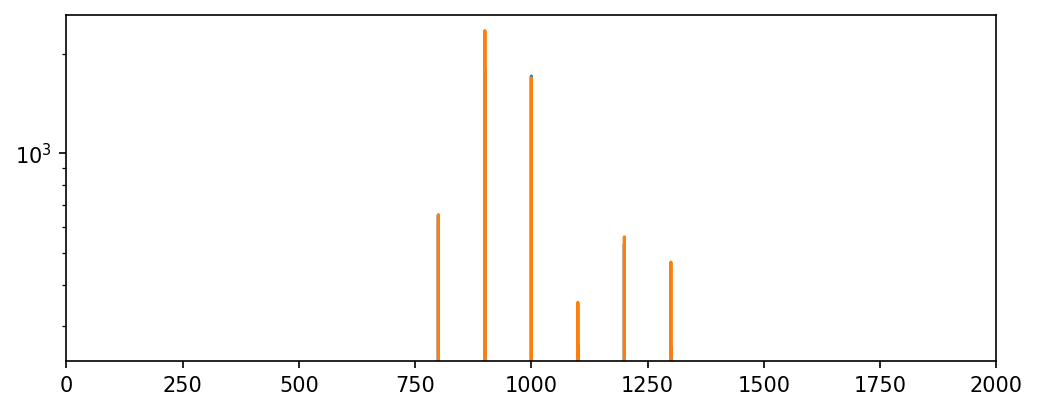

In [ ]:
sc_fft2 = sc_fft + fft_diff
# sc_fft2 = sc_fft.copy()

sc_fft[peaks[-1]+1+spread:peaks2[0]-spread]  = 0
sc_fft[:peaks[0]] = 0
sc_fft[peaks2[-1]+1:] = 0

sc_fft2[peaks[-1]+1+spread:peaks2[0]-spread]  = 0
sc_fft2[:peaks[0]] = 0
sc_fft2[peaks2[-1]+1:] = 0

for i in range(len(peaks)-1):
    start = peaks[i]+spread+1
    end = peaks[i+1]-spread
    sc_fft[start:end] = 0
    sc_fft2[start:end] = 0

for i in range(len(peaks2)-1):
    start = peaks2[i]+spread+1
    end = peaks2[i+1]-spread
    sc_fft[start:end] = 0
    sc_fft2[start:end] = 0

plt.plot(np.abs(sc_fft))
plt.plot(np.abs(sc_fft2))
plt.xlim(0,windowlen)
plt.yscale('log')
# plt.ylim(1e4, 1e7)
plt.show()

t_test      = np.linspace(-cyclewidth/2, cyclewidth/2, cyclelen)
sc_ifft     = np.fft.ifft(sc_fft)
sc_ifft2    = np.fft.ifft(sc_fft2)

##### storing results

In [ ]:
_0ft = sc_ifft
_0ft2 = sc_ifft2

# 6, 10mV: 22250

In [ ]:
_10ft = sc_ifft
_10ft2 = sc_ifft2

# 6, 10mV: 22205

In [ ]:
_20ft = sc_ifft
_20ft2 = sc_ifft2

# 6, 10mV: 17765

In [ ]:
_30ft = sc_ifft
_30ft2 = sc_ifft2

# 6, 10mV: 22225

In [ ]:
print(len(_0ft))

8000000


##### plots

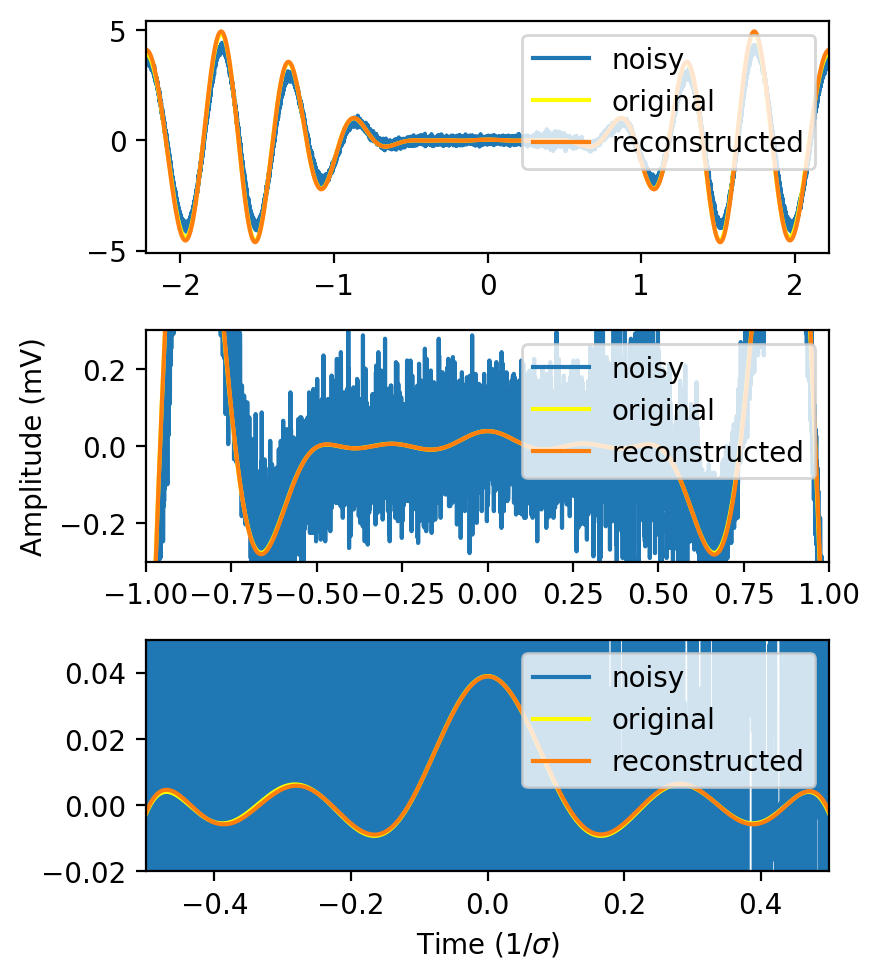

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(15,2.5), dpi=100)
fig, axs    = plt.subplots(3, 1, figsize=(4.5,5), dpi=200)
plot_x      = np.linspace(-cyclewidth/2, cyclewidth/2, cyclelen)/_sincwidth
scale2      = 1/24600
mod         = 1000      # mV

sim_one_cycle   = np.copy(np.real(y_test[int(cyclelen/2):cyclelen+int(cyclelen/2)]))*scale2
sim_one_cycle  -= np.mean(sim_one_cycle)
sim_super       = sim_one_cycle[7750:12250] - np.mean(sim_one_cycle[7750:12250])

data_one_cycle  = np.copy(np.real(data[:cyclelen]))
data_one_cycle -= np.mean(data_one_cycle)
data_super      = data_one_cycle[7750:12250] - np.mean(data_one_cycle[7750:12250])

clean_one_cycle  = np.real(_0ft)[:cyclelen]
clean_one_cycle -= np.mean(clean_one_cycle)
clean_super      = clean_one_cycle[7750:12250] - np.mean(clean_one_cycle[7750:12250])

signal_var      = np.var(data_one_cycle)
super_var       = np.var(data_super)
sim_var         = np.var(sim_one_cycle)
sim_super_var   = np.var(sim_super)
clean_var       = np.var(clean_one_cycle)
clean_super_var = np.var(clean_super)

signal_noise      = signal_var - clean_var
super_noise       = super_var - clean_super_var
clean_error       = np.var(clean_one_cycle - sim_one_cycle)
clean_super_error = np.var(clean_super - sim_super)

for ax in axs:
    ax.plot(plot_x, data_one_cycle*mod, label='noisy')
    ax.plot(plot_x, sim_one_cycle*mod, label='original', c='yellow')
    ax.plot(plot_x, clean_one_cycle*mod, label='reconstructed', c='tab:orange')
    ax.legend(loc='upper right')

axs[0].set_xlim(-cyclewidth/(2*_sincwidth), cyclewidth/(2*_sincwidth))

axs[1].set_ylabel('Amplitude (mV)')
axs[1].set_ylim(-.3, .3)
axs[1].set_xlim(-1, 1)

axs[2].set_xlabel(f'Time (1/$\sigma$)')
axs[2].set_ylim(-.02, .05)
axs[2].set_xlim(-.5, .5)

plt.tight_layout()
plt.show()

In [ ]:
print('noisy signal var:', signal_var)
print('clean signal var:', clean_var)
print('original signal var:', sim_var)
print('')

print('noisy superregion var:', super_var)
print('clean superregion var:', clean_super_var)
print('original superregion var:', sim_super_var)
print('')

print('MSE between original and reconstructed:', clean_error)
print('percentage error:', clean_error/sim_var)
print('MSE between original and reconstructed superregion:', clean_super_error)
print('percentage error:', clean_super_error/sim_super_var)
print('')

print('signal noise:', signal_noise)
print('superregion noise:', super_noise)
print('SNR:', clean_var/signal_noise)
print('superregion SNR:', clean_super_var/super_noise)

noisy signal var: 4.85356897917294e-06
clean signal var: 4.84286011548004e-06
original signal var: 4.811998219485598e-06

noisy superregion var: 8.27679872118073e-09
clean superregion var: 1.7428252679206433e-10
original superregion var: 1.6460419676104194e-10

MSE between original and reconstructed: 1.976449925422085e-09
percentage error: 0.0004107337191893989
MSE between original and reconstructed superregion: 1.4308337062009328e-12
percentage error: 0.008692571236674438

signal noise: 1.0708863692900294e-08
superregion noise: 8.102516194388666e-09
SNR: 452.22913040631323
superregion SNR: 0.021509679537914696


In [ ]:
x = np.linspace(-cyclewidth/2, cyclewidth/2, cyclelen)
bwmod = 4
wavesarr = []
for i in [0,1,2,3]:
    # dist = i*bwmod*.0375
    dist = i*bwmod*.031
    amp1 = .47
    # wave1 =  waves.create_new_wave(x, waves.SevenPeaks, [-dist/2, dist/2], [.5, amp2])
    wave1 =  waves.create_new_wave(x, waves.SixPeaks, [-dist/2, dist/2], [amp1, 1-amp1])
    wavesarr.append(wave1[:])

print(np.shape(wavesarr))

(4, 20000)


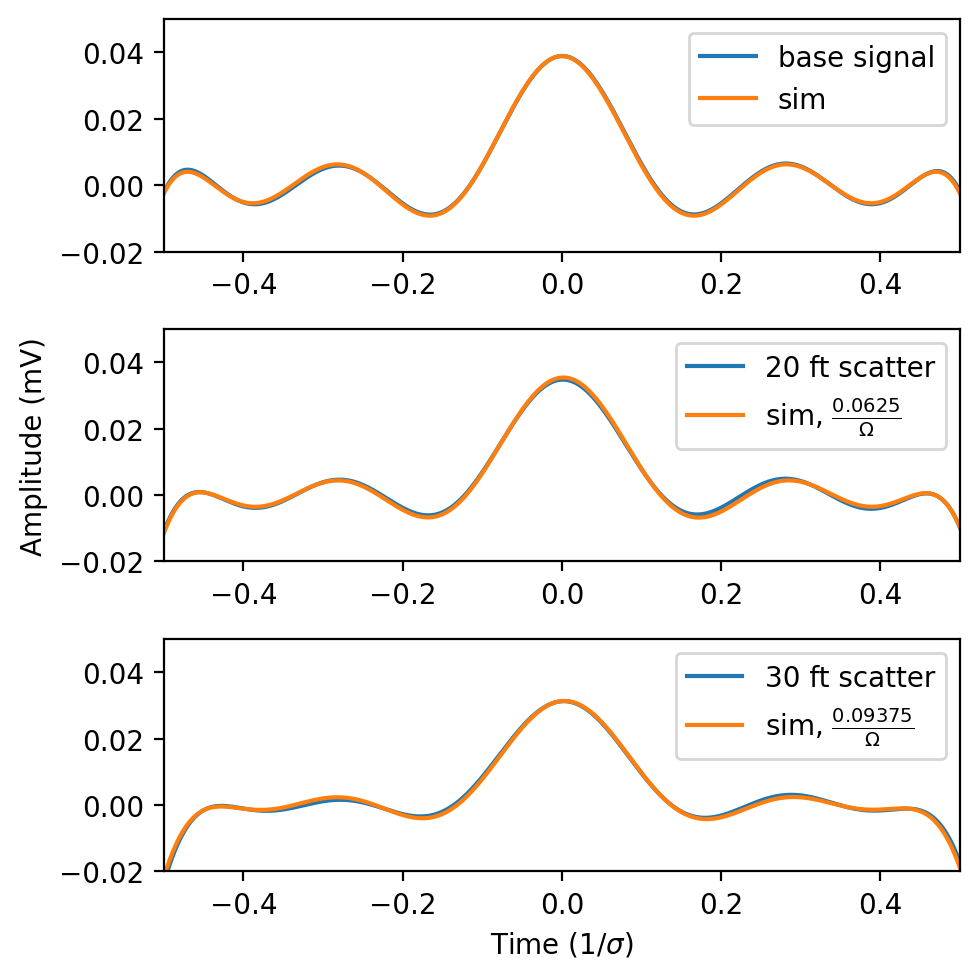

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(5,5), dpi=200)
mod2 = 24700

axs[0].plot(plot_x, np.real(_0ft[:cyclelen])*mod, label='base signal')
axs[0].plot(plot_x, np.real(wavesarr[0])*mod/mod2, label=r'sim')
axs[0].set_ylim(-.02, .05)
axs[0].set_xlim(-.5, .5)
axs[0].legend(loc='upper right')

axs[1].plot(plot_x, np.real(_20ft[:cyclelen])*mod, label='20 ft scatter')
axs[1].plot(plot_x, np.real(wavesarr[2])*mod/mod2, label=r'sim, $\frac{0.0625}{\Omega}$')
axs[1].set_ylim(-.02, .05)
axs[1].set_xlim(-.5, .5)
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Amplitude (mV)')

axs[2].plot(plot_x, np.real(_30ft[:cyclelen])*mod, label='30 ft scatter')
axs[2].plot(plot_x, np.real(wavesarr[3])*mod/mod2, label=r'sim, $\frac{0.09375}{\Omega}$')
axs[2].set_ylim(-.02, .05)
axs[2].set_xlim(-.5, .5)
axs[2].legend(loc='upper right')
axs[2].set_xlabel(f'Time (1/$\sigma$)')

plt.tight_layout()
plt.show()

# other tests

## use saved data to analyze grid search of parameters for best fit

In [5]:
pathway = '/content/drive/MyDrive/Chapman/Research/RADAR/Derek/Reconstructing_Superoscillations/'
results = np.loadtxt(pathway+'amp_and_MSE_min_results.csv', delimiter=',')
mins = pd.DataFrame(results)
mins.columns = ['N', 'Omega', 'omega_min', 'amp', 'MSE']

In [6]:
# some data cleaning
mins['N'] = mins['N'].astype(int)
mins['Omega'] = np.round(mins['Omega'], 3)

mins.head()

N  Omega  omega_min         amp       MSE
0  3    0.1      0.000  107.154770  0.062605
1  3    0.1      0.001  101.545811  0.062591
2  3    0.1      0.002   96.243134  0.062576
3  3    0.1      0.003   91.232747  0.062561
4  3    0.1      0.004   86.500673  0.062545

### amp and MSE as function of Omega (left) and of N (right)

In [7]:
O25 = mins[mins['Omega'] == .25]
min_mse_N = O25.groupby('N')['MSE'].min()
min_amp_N = O25.groupby('N')['amp'].min()

O5 = mins[mins['Omega'] == .5]
min_mse_N2 = O5.groupby('N')['MSE'].min()
min_amp_N2 = O5.groupby('N')['amp'].min()

In [8]:
N6 = mins[mins['N'] == 6]
min_mse_O = N6.groupby('Omega')['MSE'].min()
min_amp_O = N6.groupby('Omega')['amp'].min()

N15 = mins[mins['N'] == 18]
min_mse_O2 = N15.groupby('Omega')['MSE'].min()
min_amp_O2 = N15.groupby('Omega')['amp'].min()

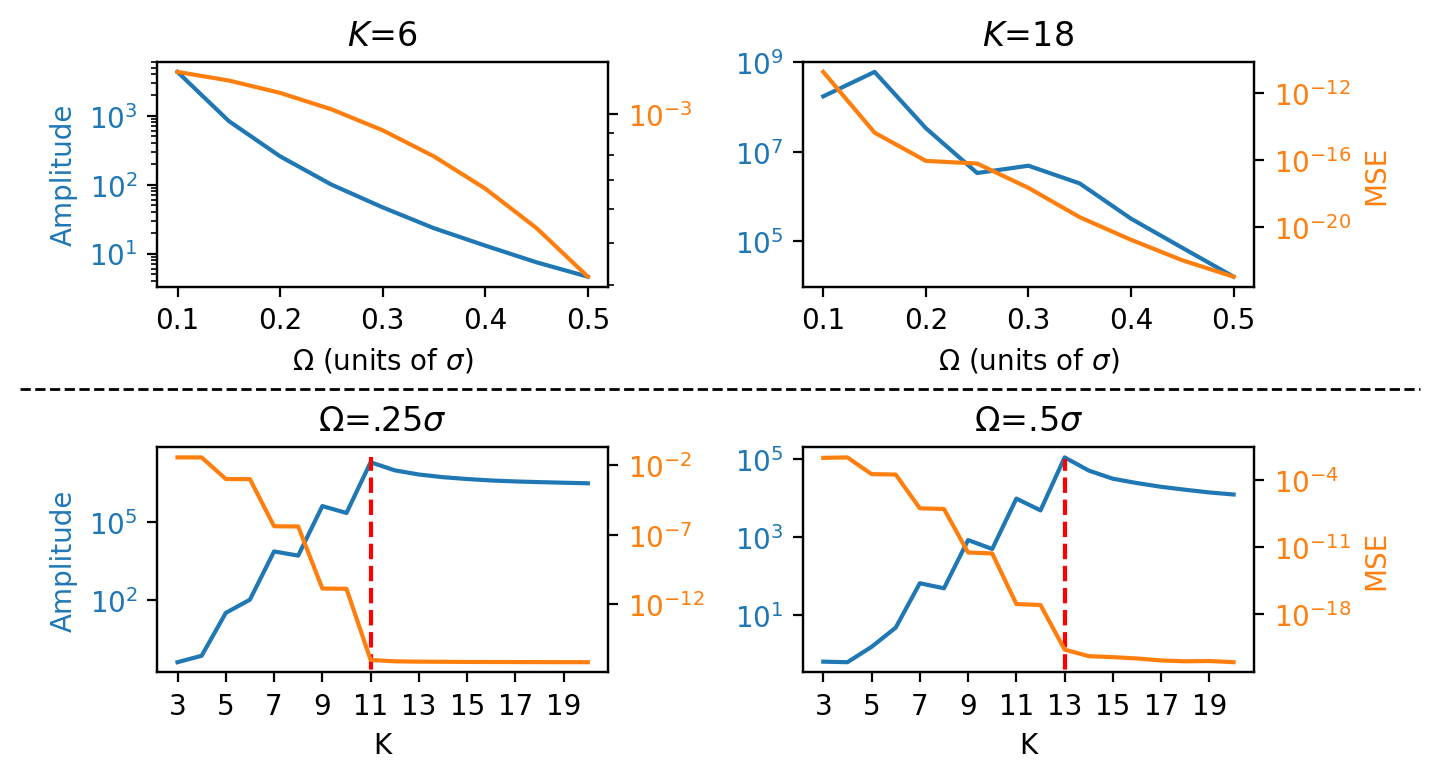

In [9]:
plt.rcParams['figure.dpi'] = 200
fig = plt.figure(figsize=(7, 4))
gs = fig.add_gridspec(2, 2, height_ratios=[0.5, 0.5])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.set_title(r'$K$=6')
ax1.plot(min_amp_O, color='tab:blue', label=r'amp')
ax1.set_xlabel(r'$\Omega$ (units of $\sigma$)')
ax1.set_ylabel('Amplitude', color='tab:blue')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1a = ax1.twinx()
ax1a.plot(min_mse_O, color='tab:orange', label=r'MSE')
ax1a.tick_params(axis='y', labelcolor='tab:orange', which='major')
ax1a.tick_params(axis='y', which='minor', labelright=False)
# ax1a.set_ylabel('MSE', color='tab:orange')
ax1a.set_yscale('log')

ax2.set_title(r'$K$=18')
ax2.plot(min_amp_O2, color='tab:blue', label=r'amp')
ax2.set_xlabel(r'$\Omega$ (units of $\sigma$)')
# ax2.set_ylabel('Amplitude', color='tab:blue')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2a = ax2.twinx()
ax2a.plot(min_mse_O2, color='tab:orange', label=r'MSE')
ax2a.tick_params(axis='y', labelcolor='tab:orange', which='major')
ax2a.tick_params(axis='y', which='minor', labelright=False)
ax2a.set_ylabel('MSE', color='tab:orange')
ax2a.set_yscale('log')

ax3.set_title(r'$\Omega$=.25$\sigma$')
ax3.plot(min_amp_N, color='tab:blue', label=r'amp')
ax3.set_xlabel(r'K')
ax3.set_ylabel('Amplitude', color='tab:blue')
ax3.set_yscale('log')
ax3.set_xticks(range(3, 21, 2))
ax3.tick_params(axis='y', labelcolor='tab:blue')
ax3.vlines(11, 0, 3e7, linestyles='dashed', color='red')

ax3a = ax3.twinx()
ax3a.plot(min_mse_N, color='tab:orange', label=r'MSE')
# ax3a.set_ylabel('MSE', color='tab:orange')
ax3a.set_yscale('log')
ax3a.tick_params(axis='y', labelcolor='tab:orange')

ax4.set_title(r'$\Omega$=.5$\sigma$')
ax4.plot(min_amp_N2, color='tab:blue', label=r'amp')
ax4.set_xlabel(r'K')
# ax4.set_ylabel('Amplitude', color='tab:blue')
ax4.set_yscale('log')
ax4.set_xticks(range(3, 21, 2))
ax4.tick_params(axis='y', labelcolor='tab:blue')
ax4.vlines(13, 0, 1e5, linestyles='dashed', color='red')

ax4a = ax4.twinx()
ax4a.plot(min_mse_N2, color='tab:orange', label=r'MSE')
ax4a.set_ylabel('MSE', color='tab:orange')
ax4a.set_yscale('log')
ax4a.tick_params(axis='y', labelcolor='tab:orange')

line = Line2D([0, 1], [0.5, 0.5], transform=fig.transFigure, color="black", linestyle="--", linewidth=1)
fig.add_artist(line)

plt.tight_layout()
plt.show()

### amp and MSE as a function of omega_min for fixed N and Omega

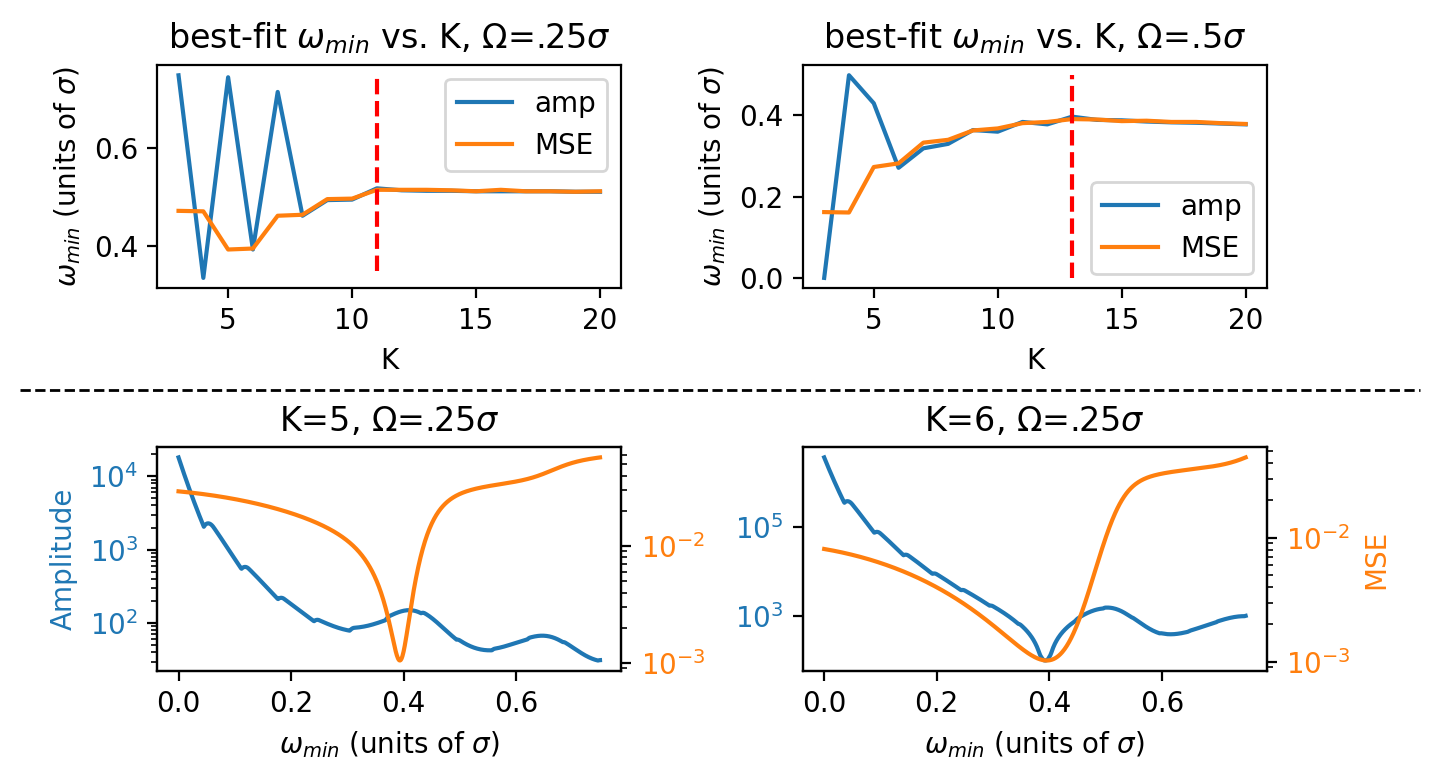

In [ ]:
O25 = mins[mins['Omega'] == .25]
min_mse_rows = O25.loc[O25.groupby('N')['MSE'].idxmin()]
min_amp_rows = O25.loc[O25.groupby('N')['amp'].idxmin()]

O5 = mins[mins['Omega'] == .5]
min_mse_rows2 = O5.loc[O5.groupby('N')['MSE'].idxmin()]
min_amp_rows2 = O5.loc[O5.groupby('N')['amp'].idxmin()]

N6O25 = mins[(mins['N'] == 6) & (mins['Omega'] == .25)]
N5O25 = mins[(mins['N'] == 5) & (mins['Omega'] == .25)]

# Create the figure and the gridspec
fig = plt.figure(figsize=(7, 4))
gs = fig.add_gridspec(2, 2, height_ratios=[0.5, 0.5])

ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

# Plot the data on the subplots
# ax3 = fig.add_subplot(gs[1, :])

ax1.set_title(r'K=5, $\Omega$=.25$\sigma$')
ax1.plot(N5O25['omega_min'], N5O25['amp'], color='tab:blue')
ax1.set_xlabel(r'$\omega_{min}$ (units of $\sigma$)')
ax1.set_ylabel('Amplitude', color='tab:blue')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1a = ax1.twinx()
ax1a.plot(N5O25['omega_min'], N5O25['MSE'], label='MSE', color='tab:orange')
# ax1a.set_ylabel('MSE', color='tab:orange')
ax1a.set_yscale('log')
ax1a.tick_params(axis='y', labelcolor='tab:orange')

ax2.set_title(r'K=6, $\Omega$=.25$\sigma$')
ax2.plot(N6O25['omega_min'], N6O25['amp'], color='tab:blue')
ax2.set_xlabel(r'$\omega_{min}$ (units of $\sigma$)')
# ax2.set_ylabel('Amplitude', color='tab:blue')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2a = ax2.twinx()
ax2a.plot(N6O25['omega_min'], N6O25['MSE'], label='MSE', color='tab:orange')
ax2a.set_ylabel('MSE', color='tab:orange')
ax2a.set_yscale('log')
ax2a.tick_params(axis='y', labelcolor='tab:orange')

ax3.plot(min_amp_rows['N'], min_amp_rows['omega_min'])
ax3.plot(min_mse_rows['N'], min_mse_rows['omega_min'])
ax3.vlines(11, 0.35, 0.75, linestyles='dashed', color='red')
ax3.set_title(r'best-fit $\omega_{min}$ vs. K, $\Omega$=.25$\sigma$')
ax3.set_xlabel('K')
ax3.set_ylabel('$\omega_{min}$ (units of $\sigma$)')
ax3.legend(['amp', 'MSE'], loc='upper right')

ax4.plot(min_amp_rows2['N'], min_amp_rows2['omega_min'])
ax4.plot(min_mse_rows2['N'], min_mse_rows2['omega_min'])
ax4.vlines(13, 0.0, 0.5, linestyles='dashed', color='red')
ax4.set_title(r'best-fit $\omega_{min}$ vs. K, $\Omega$=.5$\sigma$')
ax4.set_xlabel('K')
ax4.set_ylabel('$\omega_{min}$ (units of $\sigma$)')
ax4.legend(['amp', 'MSE'], loc='lower right')

line = Line2D([0, 1], [0.5, 0.5], transform=fig.transFigure, color="black", linestyle="--", linewidth=1)
fig.add_artist(line)

plt.tight_layout()
plt.show()

In [ ]:
# exclude all rows from mins whose amp values are 0
# these records did not have a local minimum amplitude
mins2 = mins[mins['amp'] != 0]
# mins2 = mins2[round(mins2['MSE'], 3) <= .001]
mins2 = mins2[mins2['N'] == 6]
mins2 = mins2[round(mins2['Omega'], 3) == .25]

In [ ]:
print(mins2[mins2['MSE'] == mins2['MSE'].min()])
print('')
print(mins2[mins2['amp'] == mins2['amp'].min()])

       N  Omega  omega_min        amp       MSE
21845  6   0.25      0.395  101.20773  0.001023

       N  Omega  omega_min         amp       MSE
21843  6   0.25      0.393  100.038739  0.001024


## noise test

I'm concerned that as we zoom on the scope, it changes the noise resolution

results: indeed it does change the noise.

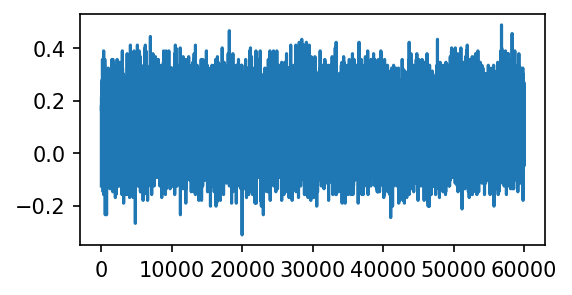

0.007850533772836983


In [ ]:
start = 2300
filelen = 60000
cyclelen = 12000
_sinclength = 1000
_sincwidth = 5
N       = 6
maxfreq = .5
cyclewidth = N/maxfreq
ratio = cyclewidth/_sincwidth

# file = pd.read_csv(filepath+'001v_20ft.csv')
file = pd.read_csv('noise_20v0.csv')
data = np.array(file['CH1V'])[start:start+filelen]

plt.plot(data)
plt.show()

print(np.var(data-np.mean(data)))

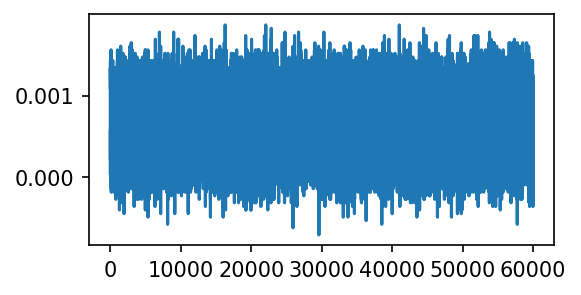

1.012105879040269e-07


In [ ]:
start = 2300
filelen = 60000
cyclelen = 12000
_sinclength = 1000
_sincwidth = 5
N       = 6
maxfreq = .5
cyclewidth = N/maxfreq
ratio = cyclewidth/_sincwidth

# file = pd.read_csv(filepath+'001v_20ft.csv')
file = pd.read_csv('noise_p16v0.csv')
data = np.array(file['CH1V'])[start:start+filelen]

plt.plot(data)
plt.show()

print(np.var(data-np.mean(data)))

## noise test 2

If we use noise with the same std dev, but with more data points vs. fewer, what happens to the PSD?

### infinite and continuous

In [ ]:
# infinite and continuous
# energy per frequency does not change regardless of N
for N in [100, 1000, 10000, 100000, 1000000, 10000000, 100000000]:
    y = np.random.normal(0, 1, N)
    f = np.fft.fft(y)/np.sqrt(N)
    print(np.var(f))
    plt.plot(np.abs(f)**2)
    plt.show()

### finite and continuous

In [ ]:
# continuous and finite
# number of cycles stays the same, but samples increases (sampling rate increases):
# energy per frequency grows proportionally with N
for N in [100, 1000, 10000, 100000, 1000000, 10000000]:
    x = np.linspace(-100, 100, N)
    y = np.sin(x)/x
    f = np.fft.fft(y)/np.sqrt(N)
    plt.plot(np.abs(f)**2)
    plt.show()

In [ ]:
# continuous and finite
# number of cycles changes, sampling rate stays constant:
# energy per frequency decreases at 1/N
for N in [100, 1000, 10000, 100000, 1000000, 10000000]:
    x = np.linspace(-N/10, N/10, N)
    y = np.sin(x)/x
    f = np.fft.fft(y)/np.sqrt(N)
    plt.plot(np.abs(f)**2)
    plt.show()

### finite and discrete

In [ ]:
# finite and discrete
# number of cycles changes, sampling rate stays constant:
# energy per frequency grows linearly with N
for N in [100, 1000, 10000, 100000, 1000000, 10000000, 100000000]:
    x = np.linspace(-N/10, N/10, N)
    y = np.zeros(N)
    for i in range(1,6):
        y += np.sin(i*x)
    f = np.fft.fft(y)/np.sqrt(N)
    plt.plot(np.abs(f)**2)
    plt.show()

In [ ]:
# finite and discrete
# number of cycles changes, sampling rate stays constant:
# energy per frequency grows linearly with N
for N in [100, 1000, 10000, 100000, 1000000, 10000000, 100000000]:
    x = np.linspace(-10, 10, N)
    y = np.zeros(N)
    for i in range(1,6):
        y += np.sin(i*x)
    f = np.fft.fft(y)/np.sqrt(N)
    plt.plot(np.abs(f)**2)
    plt.show()

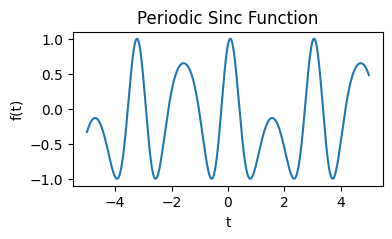

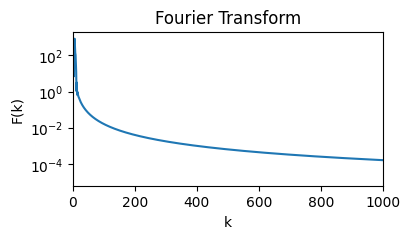

4054.4210182672705
4054.42101826727


In [ ]:
cycles = 10
timesteps = cycles * 1000

t = np.linspace(-cycles/2, cycles/2, timesteps)
y = np.sin((np.sin(t)+4)*5)
# y = np.random.normal(0, 1, timesteps)
# y = np.sin(t)/t
f = np.fft.fft(y)/np.sqrt(timesteps)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (4,2)

plt.plot(t, y)
plt.title("Periodic Sinc Function")
plt.xlabel("t")
plt.ylabel("f(t)")
# plt.xlim(-1, 1)
plt.show()

plt.plot(np.abs(f)**2)
plt.title("Fourier Transform")
plt.xlabel("k")
plt.ylabel("F(k)")
plt.xlim(0,int(timesteps/10))
plt.yscale('log')
plt.show()

print(np.sum(y**2))
print(np.sum(np.abs(f)**2))

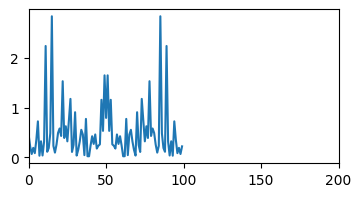

10 2.841706607875629


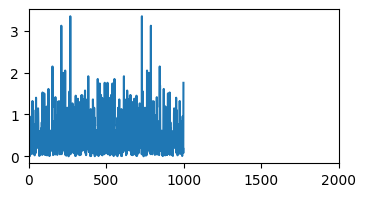

100 3.3433977374276913


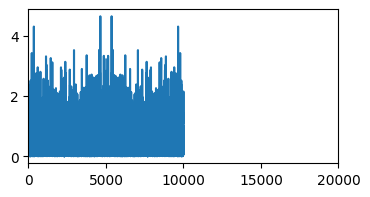

1000 4.6487904721542215


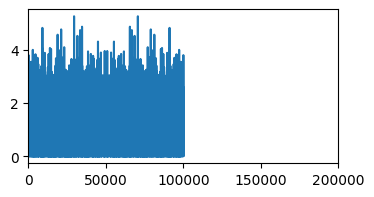

10000 5.26408783158931


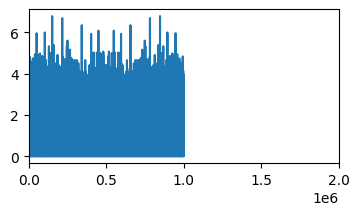

100000 6.795170685854618


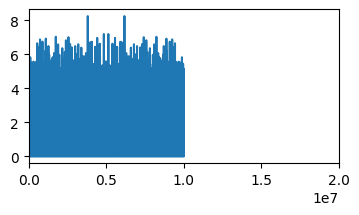

1000000 8.240053968168944


In [ ]:
# increasing timesteps per cycle increases max(f), does not widen f
# increasing nuber of cycles does not increase max(f)
cycles = 10
rate = 10
mod = 10
for cycles in (10, 100, 1000, 10000, 100000, 1000000):

    t = np.linspace(-cycles/2, cycles/2, cycles*rate)
    y = np.sin((np.sin(t)+2)*t*mod)
    f = np.fft.fft(y)/np.sqrt(cycles*rate)

    plt.plot(np.abs(f)**2)
    plt.xlim(0, cycles*mod*2)
    plt.show()

    print(cycles, np.max(np.abs(f))**2)

## poisson waves

Guided by what I was seeing in experiment, I want to see what happens if we construct a wave in the frequency space, where the amplitude and location of each frequency spike is governed by a poisson distribution.

In [ ]:
import numpy as np
def poisson_distribution(N, sigma):
    steps = [i for i in range(N)]
    amps = np.zeros(N)
    for i in range(len(steps)):
        amps[i] = sigma**steps[i] * np.exp(-sigma) / math.factorial(steps[i])
    return steps, amps

dist = poisson_distribution(8, 1.5)

plt.plot(dist[0], dist[1])
plt.show()

## matched filtering for noise reduction

the claim was made that if we only looked at the superregion, we'd never be able to get rid of the noise. I don't think that's true.

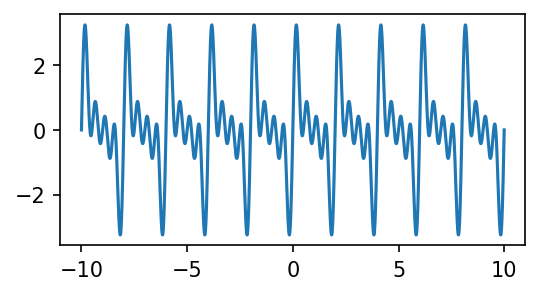

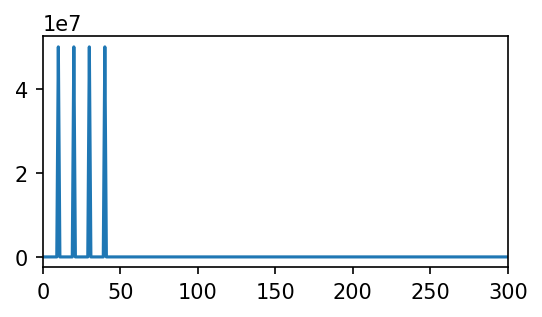

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,2)

x       = np.linspace(-10, 10, 100000000)
cap     = min(1000000,len(x))
wave    = np.sin(x*np.pi) + np.sin(2*x*np.pi) + np.sin(3*x*np.pi) + np.sin(4*x*np.pi)
fwave   = np.fft.fft(wave)

plt.plot(x, wave)
plt.show()

plt.plot(np.abs(fwave)[:cap])
plt.xlim(0,300)
plt.show()

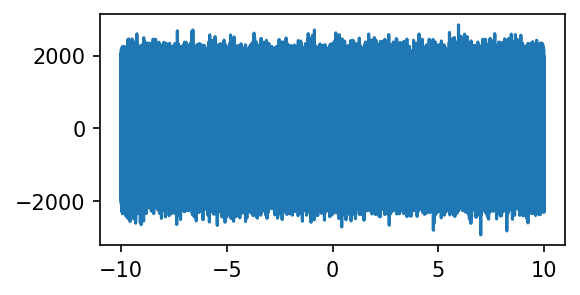

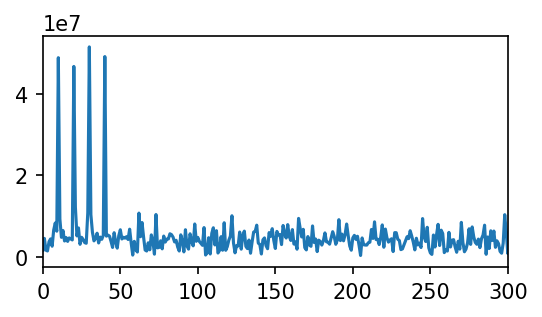

In [ ]:
nwave   = wave + np.random.normal(0, 500, len(wave))
fnwave  = np.fft.fft(nwave)

plt.plot(x, nwave)
plt.show()

plt.plot(np.abs(fnwave)[:cap])
plt.xlim(0,300)
plt.show()

In [ ]:
peaks, vals     = ss.find_peaks(np.abs(fnwave)[:5000], height=3e5)
peaks2, vals2   = ss.find_peaks(np.abs(fnwave)[-5000:], height=3e5)
peaks2         -= 5000
peaks           = np.sort(peaks[np.argsort(vals['peak_heights'])[::-1]][:4])
peaks2          = np.sort(peaks2[np.argsort(vals2['peak_heights'])[::-1]][:4])

print(peaks)
print(peaks2)

[10 20 30 40]
[-40 -30 -20 -10]


In [ ]:
sc_fft = fnwave.copy()
spread = 0

sc_fft[peaks[-1]+1+spread:peaks2[0]-spread]  = 0
sc_fft[:peaks[0]] = 0
sc_fft[peaks2[-1]+1:] = 0

sc_fft[peaks[-1]+1+spread:peaks2[0]-spread]  = 0
sc_fft[:peaks[0]] = 0
sc_fft[peaks2[-1]+1:] = 0

for i in range(len(peaks)-1):
    start = peaks[i]+spread+1
    end = peaks[i+1]-spread
    sc_fft[start:end] = 0

for i in range(len(peaks2)-1):
    start = peaks2[i]+spread+1
    end = peaks2[i+1]-spread
    sc_fft[start:end] = 0

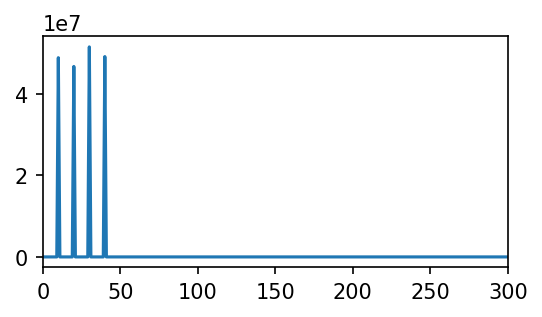

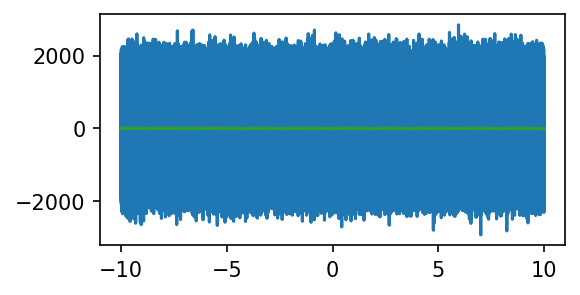

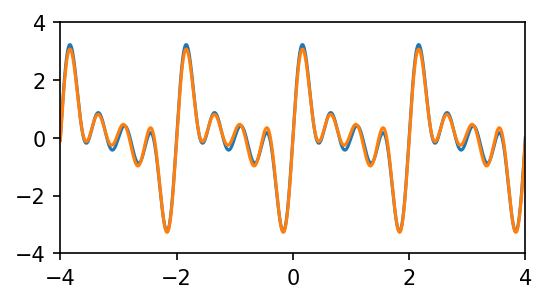

In [ ]:
sc_ifft = np.fft.ifft(sc_fft)

plt.plot(np.abs(sc_fft))
plt.xlim(0,300)
plt.show()

plt.plot(x, nwave)
plt.plot(x, wave)
plt.plot(x, np.real(sc_ifft))
plt.show()

plt.plot(x, wave)
plt.plot(x, np.real(sc_ifft))
plt.ylim(-4, 4)
plt.xlim(-4, 4)
plt.show()

In [ ]:
print(np.var(wave))
print(np.var(nwave))
print('')

print(np.var(nwave)/np.var(wave))

## supergrowth and superoscillation of a sinc wave

In [ ]:
xarray = np.linspace(-20, 20, 100000)
yarray = (np.sin(xarray) + 1j*np.cos(xarray))/xarray

dlog = np.diff(np.log(yarray))*100000/40
dreal = np.real(dlog)
dimag = np.imag(dlog)

for i in range(len(dimag)):
    if dimag[i] > 10000:
        dimag[i] = (dimag[i+1] + dimag[i-1])/2

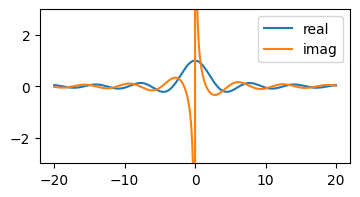

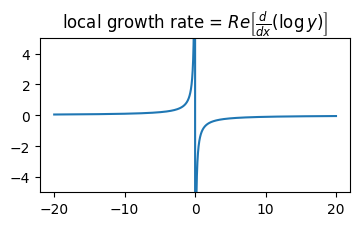

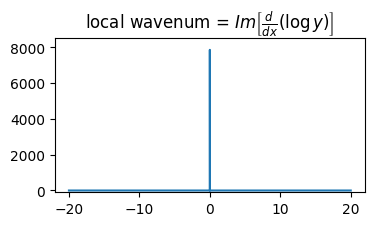

In [ ]:
plt.plot(xarray, np.real(yarray), label='real')
plt.plot(xarray, np.imag(yarray), label='imag')
plt.legend(loc='upper right')
plt.ylim(-3, 3)
plt.show()


plt.plot(xarray[:-1], dreal)
plt.ylim(-5, 5)
plt.title(r'local growth rate = $Re\left[\frac{d}{dx}\left(\log{y}\right)\right]$')
plt.show()

plt.plot(xarray[:-1], dimag)
plt.ylim(-100, 8500)
plt.title(r'local wavenum = $Im\left[\frac{d}{dx}\left(\log{y}\right)\right]$')
plt.show()

## supergrowth and superoscillation of a scattered wave

can we detect change in the supergrowth locations when a wave scatters?

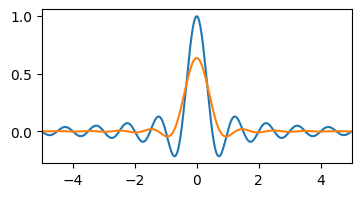

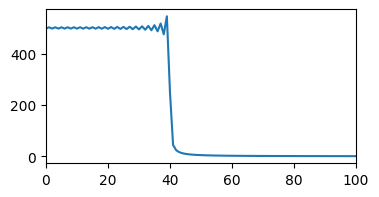

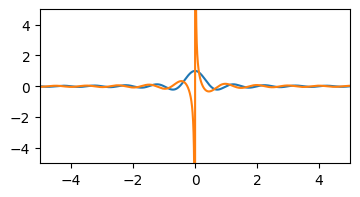

In [ ]:
t_test      = np.linspace(-20, 20, 40000)
separation  = .5
k           = separation/2
ymod        = 2*np.pi
y_plain     = (np.sin(ymod*t_test) + 1j*np.cos(ymod*t_test))/(ymod*t_test)
y_left      = (np.sin(ymod*(t_test+k)) + 1j*np.cos(ymod*(t_test+k)))/(ymod*(t_test+k))
y_right     = (np.sin(ymod*(t_test-k)) + 1j*np.cos(ymod*(t_test-k)))/(ymod*(t_test-k))
y_both      = (y_left + y_right)/2

plt.plot(t_test, np.real(y_plain))
plt.plot(t_test, np.real(y_both))
plt.xlim(-5, 5)
plt.show()

plt.plot(np.abs(np.fft.fft(np.real(y_plain))))
plt.xlim(0,100)
plt.show()

plt.plot(t_test, np.real(y_plain))
plt.plot(t_test, np.imag(y_plain))
plt.ylim(-5, 5)
plt.xlim(-5, 5)
plt.show()

In [ ]:
n_real  = np.random.normal(0, .1, len(t_test))
n_imag  = 1j*np.random.normal(0, .1, len(t_test))
noise   = n_real + n_imag
n_plain = y_plain + noise
n_both  = y_both + noise

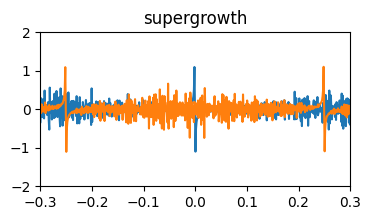

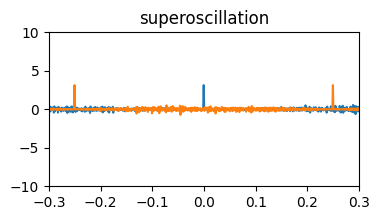

In [ ]:
def dlog(wave):
    return np.diff(np.log(wave))

dreal1 = np.real(dlog(y_plain))
dreal2 = np.real(dlog(y_both))
dimag1 = np.imag(dlog(y_plain))
dimag2 = np.imag(dlog(y_both))
nreal1 = np.real(dlog(n_plain))
nreal2 = np.real(dlog(n_both))
nimag1 = np.imag(dlog(n_plain))
nimag2 = np.imag(dlog(n_both))

plt.title('supergrowth')
# plt.plot(t_test[:-1], dreal1)
# plt.plot(t_test[:-1], dreal2)
plt.plot(t_test[:-1], nreal1)
plt.plot(t_test[:-1], nreal2)
plt.xlim(-.3, .3)
plt.ylim(-2, 2)
plt.show()

plt.title('superoscillation')
# plt.plot(t_test[:-1], dimag1)
# plt.plot(t_test[:-1], dimag2)
plt.plot(t_test[:-1], nimag1)
plt.plot(t_test[:-1], nimag2)
plt.xlim(-.3, .3)
plt.ylim(-10, 10)
plt.show()

# is superoscillation more robust against noise here only because a sinc
# has a massive amplitude spike in the imaginary direction near the origin?

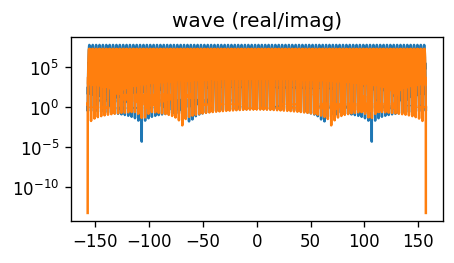

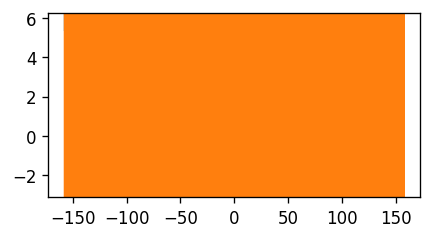

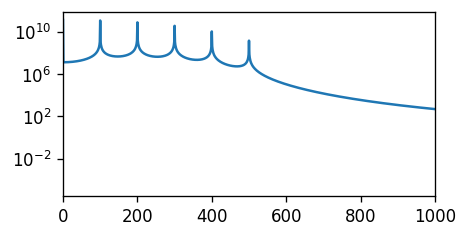

In [ ]:
N        = 10
amp      = 6
t_test   = np.linspace(-100*np.pi/2, 100*np.pi/2, 10000)
new_wave = (np.cos(t_test) + amp*1j*np.sin(t_test))**N

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (4,2)

plt.plot(t_test, np.abs(np.real(new_wave)))
plt.plot(t_test, np.abs(np.imag(new_wave)))
plt.title('wave (real/imag)')
# plt.ylim(-100, 100)
plt.yscale('log')
plt.show()

plt.plot(t_test[:-1], np.real(dlog(new_wave))*100/np.pi, label='supergrowth')
plt.plot(t_test[:-1], np.imag(dlog(new_wave))*100/np.pi, label='superoscillation')
plt.ylim(-np.pi, 2*np.pi)
plt.show()

plt.plot(np.abs(np.fft.fft(np.real(new_wave))))
plt.xlim(0,1000)
plt.yscale('log')
plt.show()

## is frequency comb phase affected by scatter? if so, how?

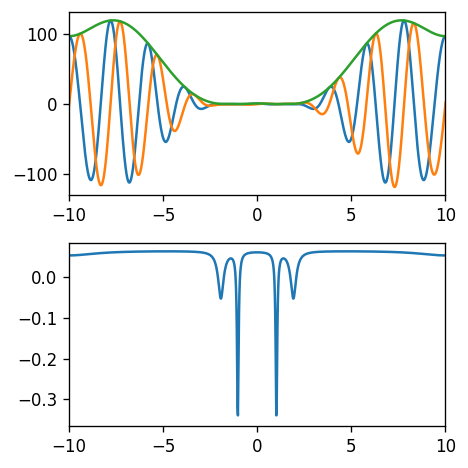

In [ ]:
x = np.linspace(-150, 150, 1000)
t = np.linspace(-100, 100, 10000)
y = waves.create_new_wave(t, waves.SixPeaks, [0], [1], _2D=True)
f = np.fft.fft(y)

fig, axs = plt.subplots(2, 1, figsize=(4,4))

axs[0].plot(t, np.real(y))
axs[0].plot(t, np.imag(y))
axs[0].plot(t, np.abs(y))
axs[0].set_xlim(-10, 10)

axs[1].plot(t[:-1], np.diff(np.unwrap(np.angle(y))))
axs[1].set_xlim(-10, 10)

plt.tight_layout()
plt.show()

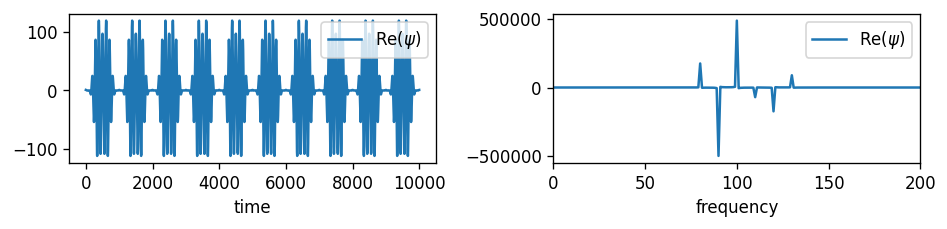

In [ ]:
# plot the phase of f as a function of each frequency. are all frequencies in phase
# with each other? intuition tells me they should be...

# nope, turns out they're not. Oni and I worked through the math to show why they're not.
# fourier frequency phase is linearly proportional to the frequency.

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (4,2)

a = np.angle(f)

for i in range(len(a)):
    while a[i] < 0:
        a[i] += np.pi

fig, axs = plt.subplots(1, 2, figsize=(8,2))

# axs[0].plot(a, label='phase(f)')
axs[0].plot(np.real(y), label=r'Re($\psi$)')
axs[0].set_xlabel('time')
axs[0].legend()

# axs[1].plot(np.fft.fftfreq(len(f)), np.real(f), label=r'Re($\psi$)')
axs[1].plot(np.real(f), label=r'Re($\psi$)')
# axs[1].plot(a, label='phase(f)')
# axs[1].plot(np.real(f)/1e5, label='real(f)')
axs[1].set_xlabel('frequency')
axs[1].set_xlim(0, 200)
axs[1].legend()

plt.tight_layout()
plt.show()

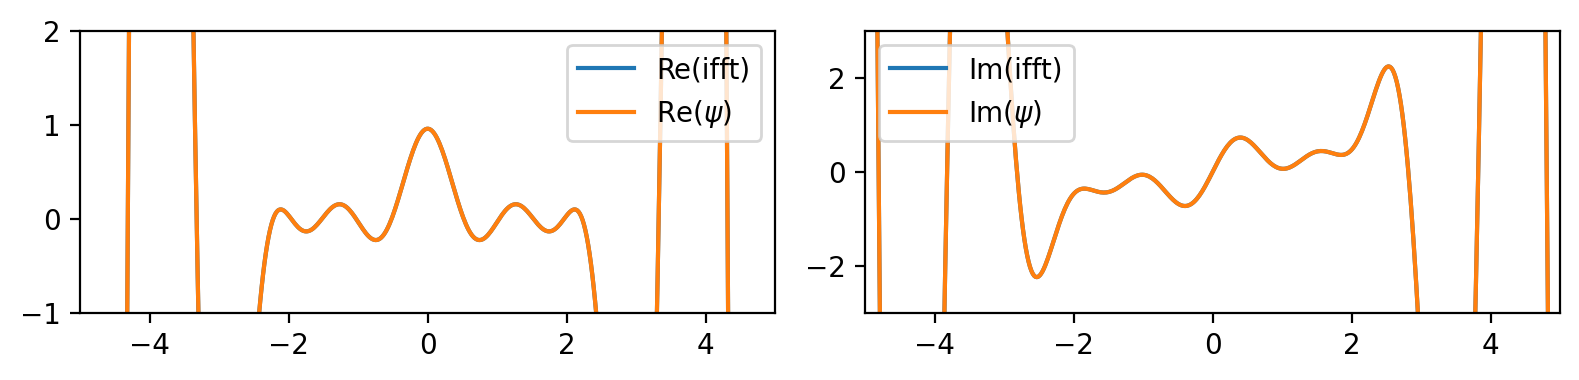

In [ ]:
# proof that the ifft gives an exact reconstruction of y

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (4,2)

f_i = np.fft.ifft(f)
f_ir = np.fft.ifft(np.real(f))
f_ii = np.fft.ifft(np.imag(f))

# plt.plot(t, np.real(f_i)/2, label='scope')
# # plt.plot(t, np.real(f_ir))
# plt.plot(t, np.real(y), label='sim')
# plt.xlim(-10, 10)
# # plt.ylim(-1, 2)
# plt.legend()
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8,2))

axs[0].plot(t, np.real(f_i), label='Re(ifft)')
# axs[0].plot(t, np.real(f_ir))
axs[0].plot(t, np.real(y), label=r'Re($\psi$)')
axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-1, 2)
axs[0].legend()

axs[1].plot(t, np.imag(f_i), label='Im(ifft)')
axs[1].plot(t, np.imag(y), label=r'Im($\psi$)')
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-3, 3)
axs[1].legend()

plt.tight_layout()
plt.show()

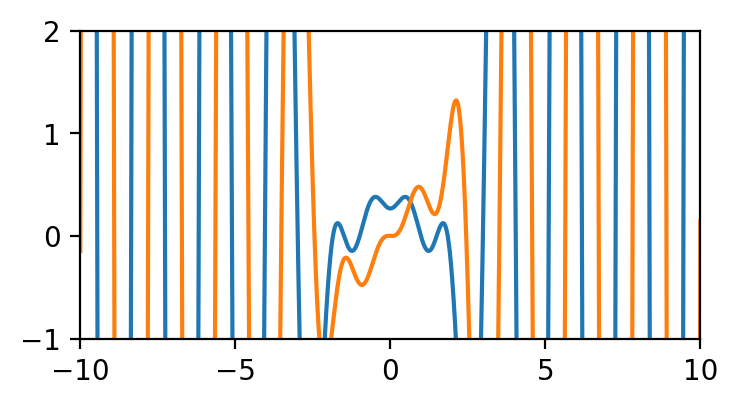

In [ ]:
# now to scatter some and see how the fourier frequencies are affected.

t2 = np.linspace(-100, 100, 100000)
y1 = waves.create_new_wave(t2, waves.SixPeaks, [0], [1], _2D=True)
y2 = waves.create_new_wave(t2, waves.SixPeaks, [-.4, .4], [.5, .5], _2D=True)

plt.plot(t2, np.real(y2))
plt.plot(t2, np.imag(y2))
plt.xlim(-10, 10)
plt.ylim(-1, 2)
plt.show()

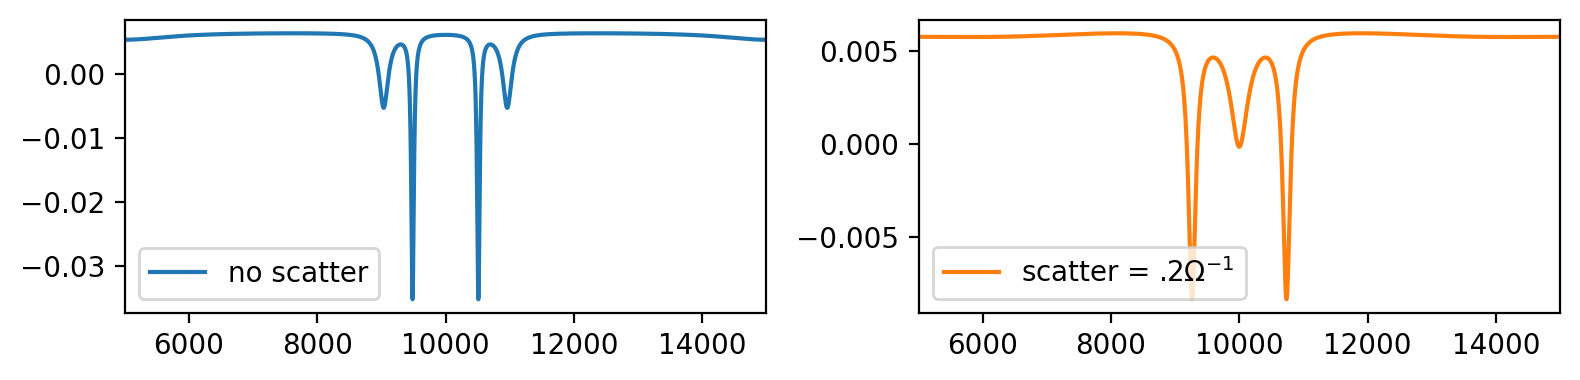

In [ ]:
f2 = np.fft.fft(np.real(y2))
f2[200:] = 0
if2 = np.fft.ifft(f2)
a2 = np.unwrap(np.angle(f2))

fig, axs = plt.subplots(1, 2, figsize=(8,2))


axs[0].plot(np.diff(np.unwrap(np.angle(y1))), label='no scatter')
# axs[0].plot(np.diff(np.unwrap(np.angle(y2))))
axs[0].set_xlim(5000, 15000)
axs[0].legend()

# axs[1].plot(np.diff(np.unwrap(np.angle(if2))))
axs[1].plot(np.diff(np.unwrap(np.angle(y2))), label=r'scatter = .2$\Omega^{-1}$', c='tab:orange')
axs[1].set_xlim(5000, 15000)
axs[1].legend()

plt.tight_layout()
plt.show()

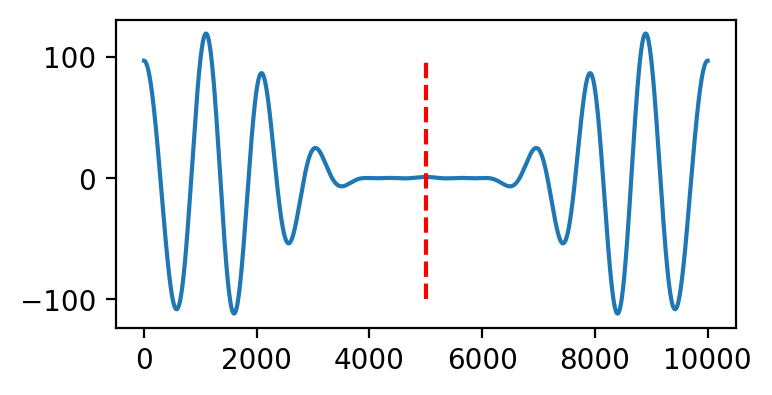

In [ ]:
t3 = np.linspace(-10, 10, 10000)
y3 = waves.create_new_wave(t3, waves.SixPeaks, [0], [1], _2D=False)

plt.plot(np.real(y3))
plt.vlines(5000, -100, 100, linestyles='dashed', colors='r')
plt.show()
# plt.xlim(0, 200)
plt.show()

In [ ]:
def update_plot(num):
    fig, axs = plt.subplots(1, 2, figsize=(8,2), dpi=200)
    for i in np.arange(0, num+.005, .01):
        ibw = i*4
        y2 = waves.create_new_wave(t3, waves.SixPeaks, [-ibw/2, ibw/2], [.5, .5], _2D=True)
        axs[0].plot(np.real(np.diff(y2))/np.abs(y2[:-1]), color=mpl.cm.RdYlBu((num-i)/num))
        axs[1].plot(np.diff(np.unwrap(np.angle(y2))), color=mpl.cm.RdYlBu((num-i)/num))
    # axs[0].plot(np.real(y2[:-1])/30, color='tab:orange')
    # axs[0].plot(np.abs(y2[:-1])/30, color='tab:cyan')
    # axs[1].plot(np.real(y2[:-1])/30, color='tab:orange')
    # axs[1].plot(np.abs(y2[:-1])/30, color='tab:cyan')
    axs[0].set_xlim(3000, 7000)
    axs[0].set_ylim(-.04, .04)
    axs[1].set_xlim(3000, 7000)
    axs[1].set_ylim(-.04, .04)
    axs[0].vlines([5000-1125, 5000+1125], -100, 100, linestyles='dashed', colors='black')
    axs[1].vlines([5000-1125, 5000+1125], -100, 100, linestyles='dashed', colors='black')
    plt.tight_layout()
    plt.show()

# Create an interactive slider
interact(update_plot, num=FloatSlider(min=.01, max=.25, step=.01))

interactive(children=(FloatSlider(value=0.01, description='num', max=0.25, min=0.01, step=0.01), Output()), _d…

<function __main__.update_plot(num)>

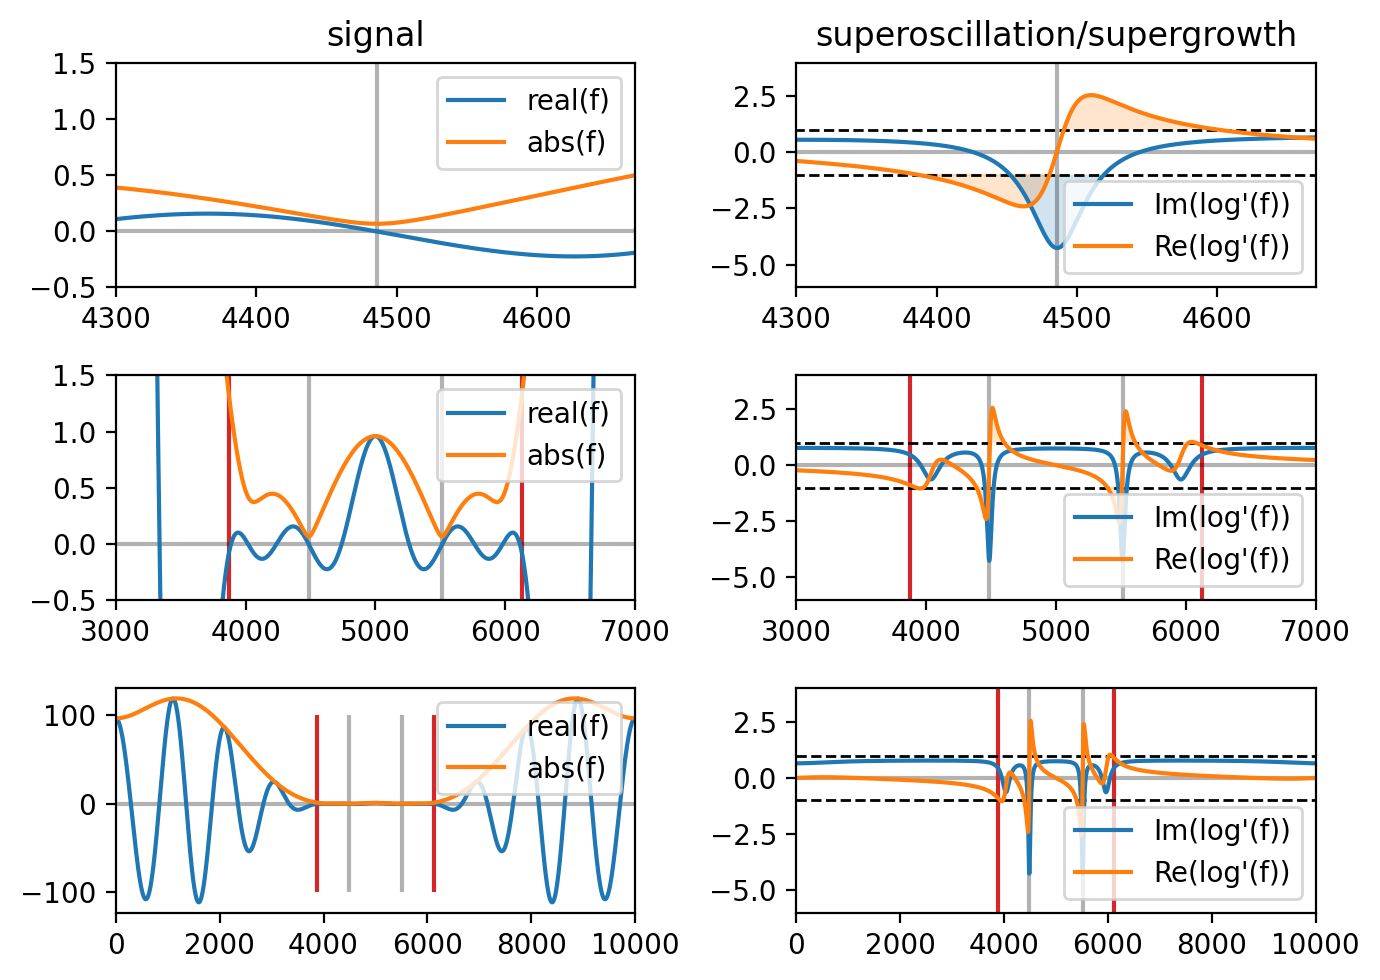

In [ ]:
y2          = waves.create_new_wave(t3, waves.SixPeaks, [0], [1], _2D=True)
amplitude   = np.abs(y2)[:-1]
frequency   = np.imag(np.diff(np.log(y2)))*500/4.12     # number of time steps per one inverse bandwidth,
growth      = np.real(np.diff(np.log(y2)))*500/4.12     # given function's bandwidth is sinc's bandwidth / 5.74
energy      = (frequency**2) * (amplitude**2)

temp_x      = range(9999)
mask        = (frequency < -1)
mask2       = (growth > 1)
mask3       = (growth < -1)

fig, axs = plt.subplots(3, 2, figsize=(7,5), dpi=200)

for i in range(len(growth)):
    if growth[i] < -10:
        growth[i] = (growth[i+1] + growth[i-1])/2
    if frequency[i] < -10:
        frequency[i] = (frequency[i+1] + frequency[i-1])/2

axs[0][0].hlines(0, 0, 10000, colors='black', alpha=.3)
axs[0][0].vlines((4486, 5512), -100, 100, colors='black', alpha=.3)
axs[0][0].plot(temp_x, np.real(y2)[:-1], label='real(f)')
axs[0][0].plot(temp_x, np.abs(y2)[:-1], label='abs(f)')
axs[0][0].legend(loc='upper right')
axs[0][0].set_xlim(4300, 4670)
axs[0][0].set_ylim(-.5, 1.5)
axs[0][0].set_title('signal')

axs[0][1].hlines(0, 0, 10000, colors='black', alpha=.3)
axs[0][1].vlines((4486, 5512), -100, 100, colors='black', alpha=.3)
axs[0][1].hlines((-1, 1), 0, 10000, linestyles='dashed', colors='black', linewidth=1)
axs[0][1].fill_between(temp_x, frequency, -1, where=mask, alpha=.2)
axs[0][1].fill_between(temp_x, growth, 1, where=mask2, alpha=.2)
axs[0][1].fill_between(temp_x, growth, -1, where=mask3, alpha=.2, color='tab:orange')
axs[0][1].plot(temp_x, frequency,  label="Im(log'(f))")
axs[0][1].plot(temp_x, growth, label="Re(log'(f))")
axs[0][1].legend(loc='lower right')
axs[0][1].set_xlim(4300, 4670)
axs[0][1].set_ylim(-6, 4)
axs[0][1].set_title('superoscillation/supergrowth')

axs[1][0].vlines((3875, 6125), -100, 100, colors='tab:red')
axs[1][0].hlines(0, 0, 10000, colors='black', alpha=.3)
axs[1][0].vlines((4486, 5512), -100, 100, colors='black', alpha=.3)
axs[1][0].plot(temp_x, np.real(y2)[:-1], label='real(f)')
axs[1][0].plot(temp_x, np.abs(y2)[:-1], label='abs(f)')
axs[1][0].legend(loc='upper right')
axs[1][0].set_xlim(3000, 7000)
axs[1][0].set_ylim(-.5, 1.5)

axs[1][1].vlines((3875, 6125), -100, 100, colors='tab:red')
axs[1][1].hlines(0, 0, 10000, colors='black', alpha=.3)
axs[1][1].vlines((4486, 5512), -100, 100, colors='black', alpha=.3)
axs[1][1].hlines((-1, 1), 0, 10000, linestyles='dashed', colors='black', linewidth=1)
axs[1][1].fill_between(temp_x, frequency, -1, where=mask, alpha=.2)
axs[1][1].fill_between(temp_x, growth, 1, where=mask2, alpha=.2)
axs[1][1].fill_between(temp_x, growth, -1, where=mask3, alpha=.2, color='tab:orange')
axs[1][1].plot(temp_x, frequency,  label="Im(log'(f))")
axs[1][1].plot(temp_x, growth, label="Re(log'(f))")
axs[1][1].legend(loc='lower right')
axs[1][1].set_xlim(3000, 7000)
axs[1][1].set_ylim(-6, 4)

axs[2][0].hlines(0, 0, 10000, colors='black', alpha=.3)
axs[2][0].vlines((3875, 6125), -100, 100,colors='tab:red')
axs[2][0].vlines((4486, 5512), -100, 100, colors='black', alpha=.3)
axs[2][0].plot(temp_x, np.real(y2)[:-1], label='real(f)')
axs[2][0].plot(temp_x, np.abs(y2)[:-1], label='abs(f)')
axs[2][0].legend(loc='upper right')
axs[2][0].set_xlim(0, 10000)

axs[2][1].hlines(0, 0, 10000, colors='black', alpha=.3)
axs[2][1].vlines((3875, 6125), -100, 100,colors='tab:red')
axs[2][1].vlines((4486, 5512), -100, 100, colors='black', alpha=.3)
axs[2][1].hlines((-1, 1), 0, 10000, linestyles='dashed', colors='black', linewidth=1)
axs[2][1].fill_between(temp_x, frequency, -1, where=mask, alpha=.2)
axs[2][1].fill_between(temp_x, growth, 1, where=mask2, alpha=.2)
axs[2][1].fill_between(temp_x, growth, -1, where=mask3, alpha=.2, color='tab:orange')
axs[2][1].plot(temp_x, frequency,  label="Im(log'(f))")
axs[2][1].plot(temp_x, growth, label="Re(log'(f))")
axs[2][1].legend(loc='lower right')
axs[2][1].set_xlim(0, 10000)
axs[2][1].set_ylim(-6, 4)

plt.tight_layout()
plt.show()

In [ ]:
# if we cut out both the imaginary frequencies and the negative frequencies, we should get
# a perfectly phase-centered 2D wave, right? we might need to start trying this with real data

filepath    = '/content/drive/MyDrive/Chapman/Research/3Dmapping/MLE/ghost_waves/6peaks/400kHz/'
data        = np.array(pd.read_csv(filepath+'6_10mV_8mV_0ft.csv')['CH1V'])
print(len(data))

10000000


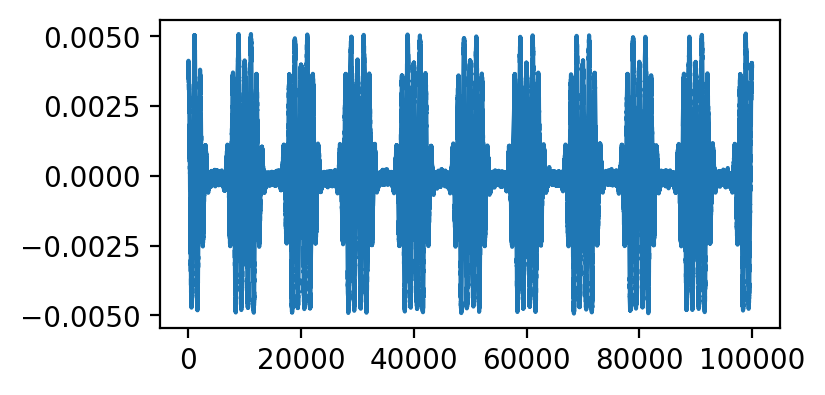

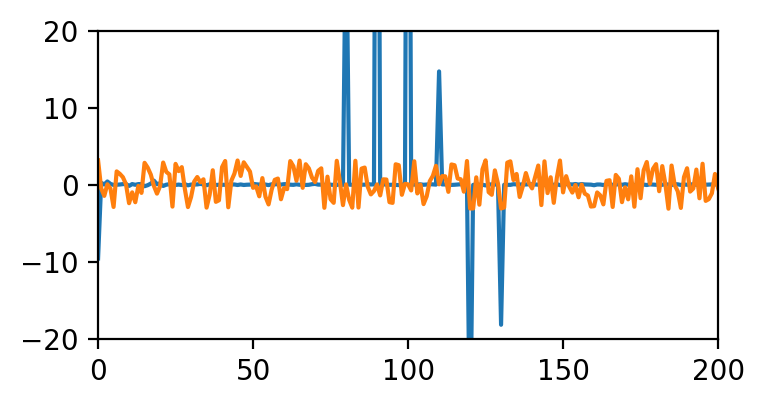

In [ ]:
start       = 1166
cyclelen    = 10000
mid         = int(cyclelen/2)
numcycles   = 10
y           = data[start:start+cyclelen*numcycles]
f           = np.fft.fft(y)
a           = np.angle(f)

plt.plot(y)
plt.show()

plt.plot(np.real(f))
plt.plot(a)
plt.ylim(-20, 20)
plt.xlim(0, 200)
plt.show()

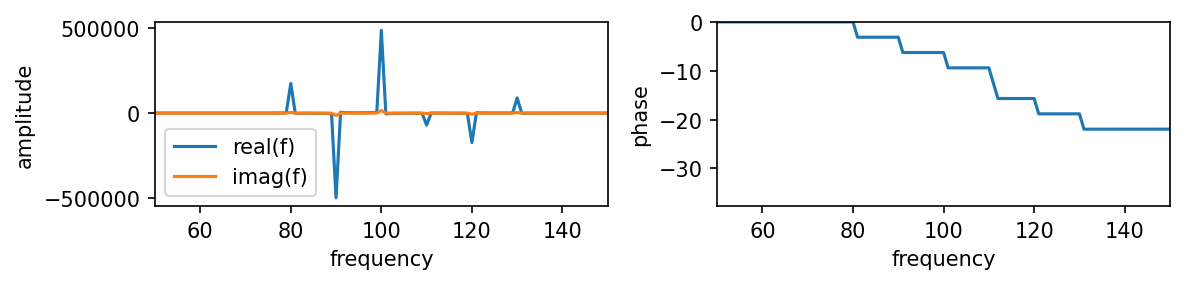

In [ ]:
f[:7]       = 0
N           = 6
# peaks       = np.sort(np.argsort(np.abs(f))[-N*2:])[:N]
# mask        = np.zeros_like(f, dtype=bool)
# mask[peaks] = True
# f[~mask]    = 0

fig, axs = plt.subplots(1, 2, figsize=(8,2))

axs[0].plot(np.real(f), label='real(f)')
axs[0].plot(np.imag(f), label='imag(f)')
# axs[0].plot(np.abs(f), label='abs(f)')
axs[0].set_ylabel('amplitude')
axs[0].set_xlabel('frequency')
axs[0].legend()
axs[0].set_xlim(50, 150)
# axs[0].set_ylim()

axs[1].plot(np.unwrap(np.angle(f)))
axs[1].set_xlabel('frequency')
axs[1].set_ylabel('phase')
axs[1].set_xlim(50, 150)
axs[1].set_ylim(-12*np.pi, 0)

plt.tight_layout()
plt.show()

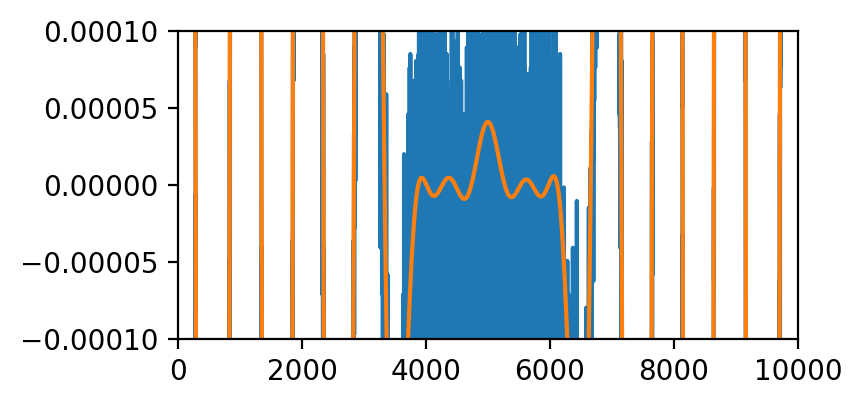

In [ ]:
ift = np.fft.ifft(f)

plt.plot(y)
plt.plot(2*np.real(ift))
plt.xlim(0, 10000)
plt.ylim(-.0001, .0001)
plt.show()

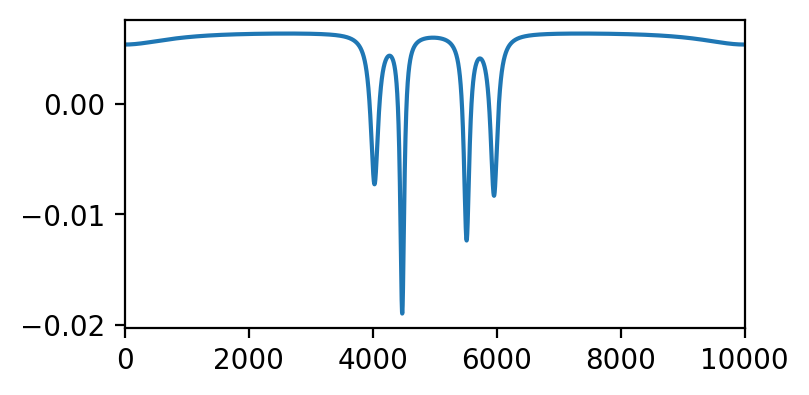

In [ ]:
plt.plot(np.diff(np.unwrap(np.angle(ift))))
plt.xlim(0, 10000)
plt.show()

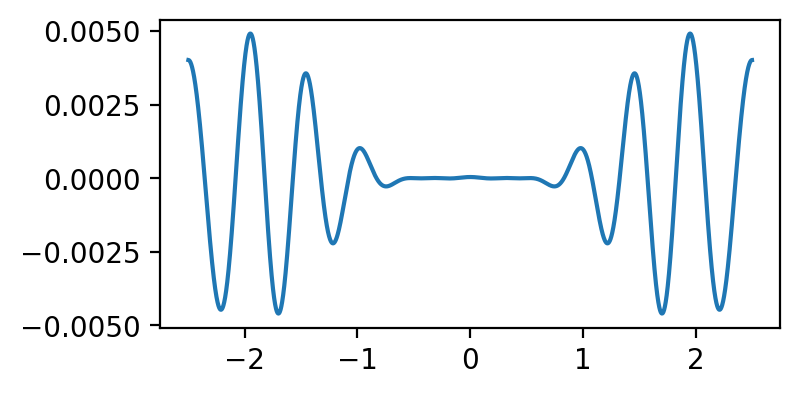

In [ ]:
cntr            = int(cyclelen/2)
sim_one_cycle   = np.copy(y_test[int(cyclelen/2):cyclelen+int(cyclelen/2)])/24300
sim_one_cycle  -= np.mean(sim_one_cycle)
t_one_cycle     = np.linspace(-2.5, 2.5, cyclelen)

plt.plot(t_one_cycle, np.real(sim_one_cycle))
plt.show()

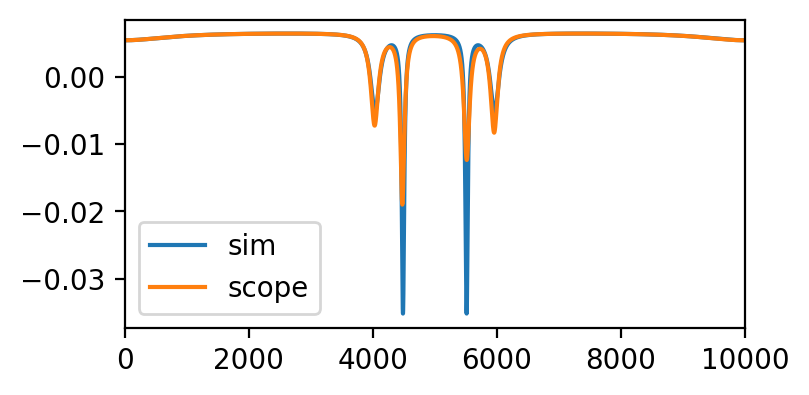

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (4,2)

plt.plot(np.diff(np.unwrap(np.angle(sim_one_cycle))), label='sim')
plt.plot(np.diff(np.unwrap(np.angle(ift))), label='scope')
plt.xlim(0, 10000)
plt.legend()
plt.show()

## should we start describing the bandwidth as the std dev of the signal's frequencies?

Maybe revisit this one. Plot the supergrowth and superoscillation plots as usual, but with the boundary bars
at mean +/- std dev instead.

This would imply that superoscillation is related to the bandwidth somehow, which may or may not be true. All we can
currently say is that superoscillation happens when the local frequency content is outside strict bandlimits. It would be interesting to see what the distribution of frequencies as a function of time looks like for waves with superoscillations: does it follow a nearly gaussian distribution, with the probability of each frequency F(t) being within the bandwidth as something like one std dev?

I am convinced there are still mathematical relationships we haven't found yet.

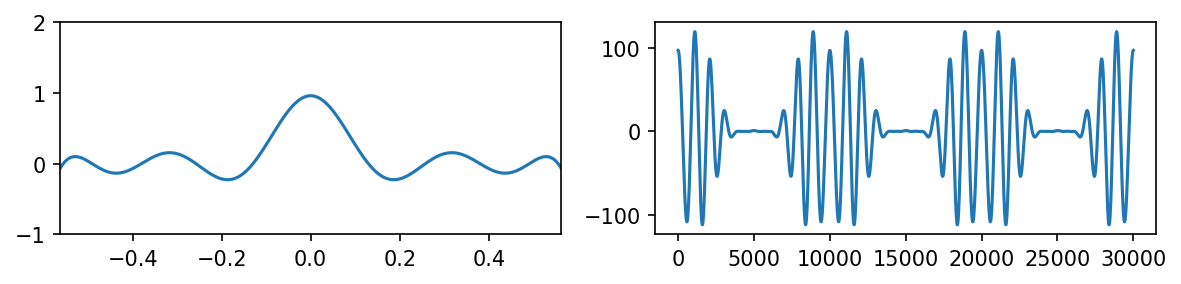

In [ ]:
cycles  = 3
width   = 20*cycles     # the full wave has a width of 20
length  = 10000*cycles  # set the wave to have a length of 10000 (user choice)
t       = np.linspace(-width/2, width/2, length)
y       = waves.create_new_wave(t, waves.SixPeaks, [0], [1], _2D=True)
f       = np.fft.fft(y)

invdt = length/width

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8,2), dpi=150)

ax.plot(t/4, np.real(y))
ax.set_xlim(-9/16, 9/16)
ax.set_ylim(-1, 2)

ax2.plot(np.real(y))
# ax2.set_xlim(-2.5, 2.5)

plt.tight_layout()
plt.show()

In [ ]:
# find 6 largest peaks in f and their locations
peaklocs = np.sort(np.argsort(np.abs(f))[-6:])
peaks = np.abs(f[peaklocs])

# normalize peaks to sum to 1; normalize peaklocs to [.4, .65]
peaks /= np.sum(peaks)
peaklocs = np.float32(peaklocs/width)
print('peaks:', peaks)
print('peak locations:', peaklocs)

peaks: [0.11756087 0.33379588 0.32598829 0.04649813 0.11646041 0.05969643]
peak locations: [0.4  0.45 0.5  0.55 0.6  0.65]


In [ ]:
# find the mean and standard deviation of peak locations, weighted by peaks
mean = np.sum(peaklocs*peaks)
std  = np.sqrt(np.sum(peaks*(peaklocs-mean)**2))
print('mean:', np.round(mean, 3))
print('std:', np.round(std, 3))

mean: 0.494
std: 0.068


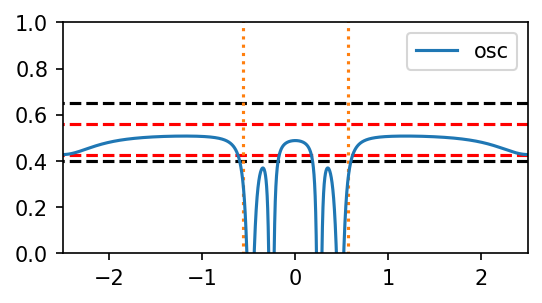

In [ ]:
# black horizonal lines indicate the strict badlimits; red indicate +/- 1 std dev from the mean frequency

osc = np.diff(np.unwrap(np.angle(y)))*invdt/(2*np.pi)
growth = np.diff(np.abs(y))/np.abs(y)[:-1]*invdt/(2*np.pi)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,2)
plt.hlines((mean+std, mean-std), -np.pi, np.pi, colors='r', linestyles='dashed')
plt.hlines((.4, .65), -np.pi, np.pi, colors='black', linestyles='dashed')
plt.vlines((-9/16, 9/16), -10, 10, colors='tab:orange', linestyles='dotted')
plt.plot(t[:-1]/4, osc, label='osc')
# plt.plot(t[:-1]/4, growth, label='growth')
plt.xlim(-2.5, 2.5)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
# show the means and std devs for the whole wave, just the lobes, and just the superregion
# no idea how coincidental it is, but the mean total oscillation frequency in time is our smallest chosen frequency
# we also see that the mean growth is basically zero (makes sense; kinda has to be in order to be cyclical)
# interestingly, the total std dev of oscillation and the total std dev of growth are identical
# I'm not sure there's much else to be gained - the outside lobes' mean is near the mean of the frequencies
# we used to construct our signal, but not close enough to necessarily be a pattern.

# I think we need to test this on other waves too to see which patterns, if any, hold for all superoscillating waves

print('total osc mean:', np.mean(osc))
print('total osc std:', np.std(osc))
print('total growth mean:', np.mean(growth))
print('total growth std:', np.std(osc))
print('')

print('lobes osc mean', np.mean(osc[6125:13875]))
print('lobes osc std dev', np.std(osc[6125:13875]))
print('lobes growth mean', np.mean(growth[6125:13875]))
print('lobes growth std dev', np.std(growth[6125:13875]))
print('')

print('super osc mean', np.mean(osc[3875:6125]))
print('super osc std dev', np.std(osc[3875:6125]))
print('super growth mean', np.mean(growth[3875:6125]))
print('super growth std dev', np.std(growth[3875:6125]))

total osc mean: 0.40001333377779213
total osc std: 0.31156535924788475
total growth mean: 0.0006099366013456198
total growth std: 0.31156535924788475

lobes osc mean 0.4828796955959006
lobes osc std dev 0.03090808106277379
lobes growth mean 9.656528463579567e-05
lobes growth std dev 0.15265188588509407

super osc mean 0.41605370908307954
super osc std dev 0.5683325767252293
super growth mean 0.43048091162271374
super growth std dev 0.5926599943674272


osc mean: 0.4000400040003997
osc std: 0.31135961490453345
growth mean: 0.0030467462984409767
growth std: 0.31135961490453345


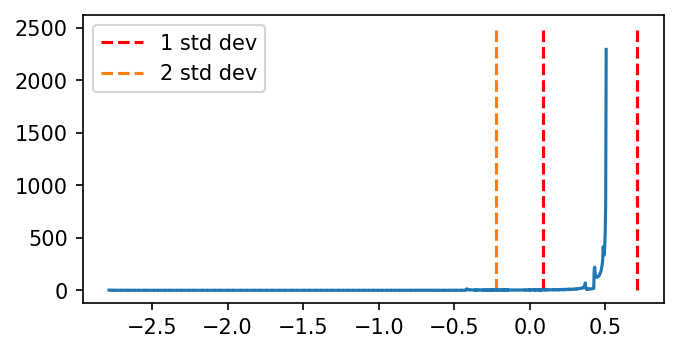

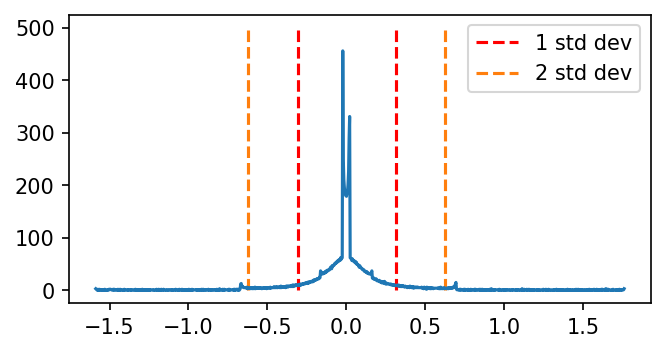

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (5, 2.5)

hist = np.histogram(osc, bins=1000)
plt.vlines((np.mean(osc)-np.std(osc), np.mean(osc)+np.std(osc)), 0, 2500,
           colors='r', linestyles='dashed', label='1 std dev')
plt.vlines((np.mean(osc)-2*np.std(osc)), 0, 2500,
           colors='tab:orange', linestyles='dashed', label='2 std dev')
plt.plot(hist[1][:-1], hist[0])
plt.legend()
plt.show()

hist2 = np.histogram(growth, bins=1000)
plt.vlines((np.mean(growth)-np.std(growth), np.mean(growth)+np.std(growth)),
           0, 500, colors='r', linestyles='dashed', label='1 std dev')
plt.vlines((np.mean(growth)-2*np.std(growth), np.mean(growth)+2*np.std(growth)),
           0, 500, colors='tab:orange', linestyles='dashed', label='2 std dev')
plt.plot(hist2[1][:-1], hist2[0])
plt.legend()
plt.show()



## John's wave - is it actually straight?

answer - nope. but I think we knew that already, no?

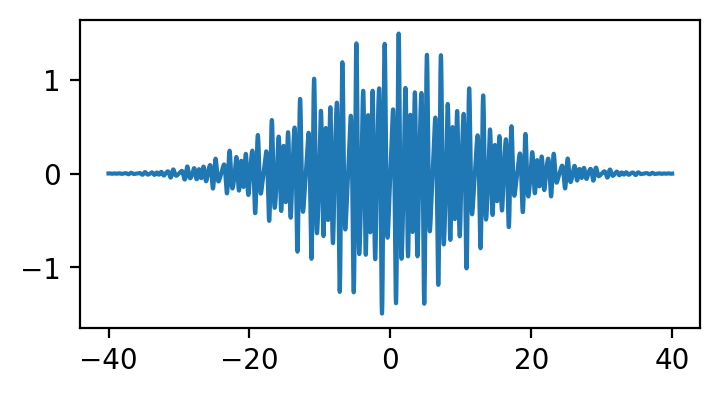

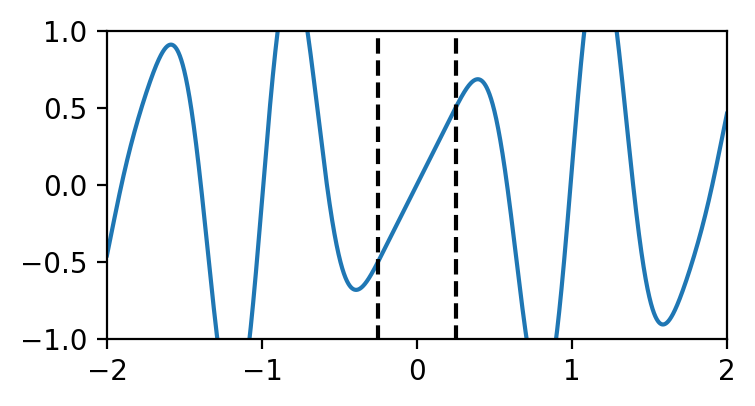

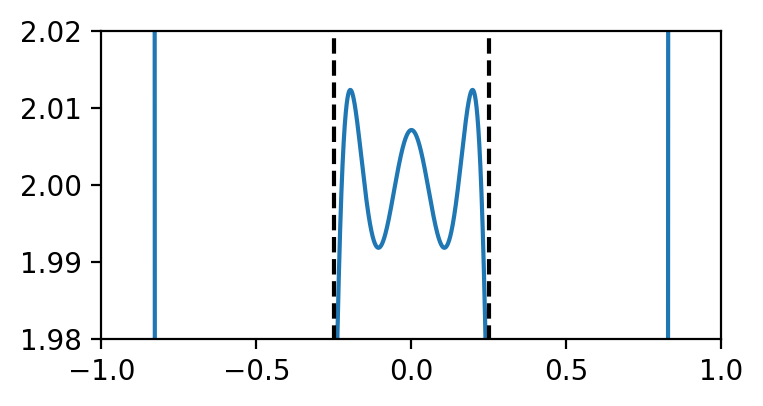

In [ ]:
invdt = 10000
width = 80
t = np.linspace(-width/2, width/2, invdt*width)
y = waves.create_new_wave(t, waves.flatline, [0], [1], _2D=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (4,2)

plt.plot(t, y)
plt.show()

plt.plot(t, y)
plt.vlines((-.25, .25), -10, 10, colors='black', linestyles='dashed')
plt.ylim(-1, 1)
plt.xlim(-2, 2)
plt.show()

plt.plot(t[:-1], np.diff(y)*invdt)
plt.vlines((-.25, .25), -10, 10, colors='black', linestyles='dashed')
plt.xlim(-1, 1)
plt.ylim(1.98, 2.02)
plt.show()

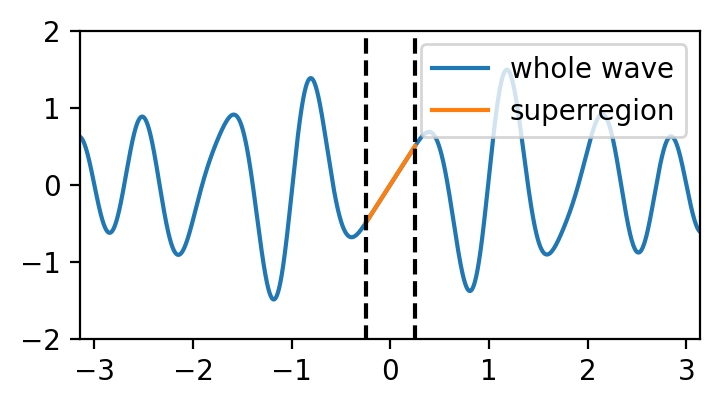

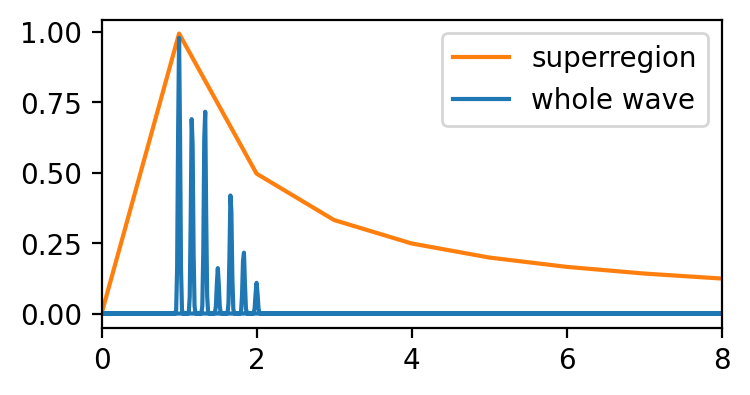

In [ ]:
from matplotlib.ticker import ScalarFormatter, EngFormatter
formatter = ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))

length  = int(width*invdt)
mid     = int(length/2)

superwidth  = .5
superlength = int(superwidth*invdt)
supermid    = int(superlength/2)
supert      = t[mid-supermid:mid+supermid]
supery      = y[mid-supermid:mid+supermid]

plt.plot(t, y, label='whole wave')
plt.plot(supert, supery, label='superregion')
plt.legend()
plt.vlines((-.25, .25), -10, 10, colors='black', linestyles='dashed')
plt.ylim(-2, 2)
plt.xlim(-np.pi, np.pi)
plt.show()

f           = np.fft.fft(y)
ffreq       = np.fft.fftfreq(length, d=1/invdt)
superf      = np.fft.fft(supery)
superfreq   = np.fft.fftfreq(superlength, d=1/invdt)

plt.plot(np.abs(superf)/800, color='tab:orange', label='superregion')
plt.plot(ffreq, np.abs(f)/100000, color='tab:blue', label='whole wave')
plt.legend()
plt.xlim(0, 8)
plt.show()

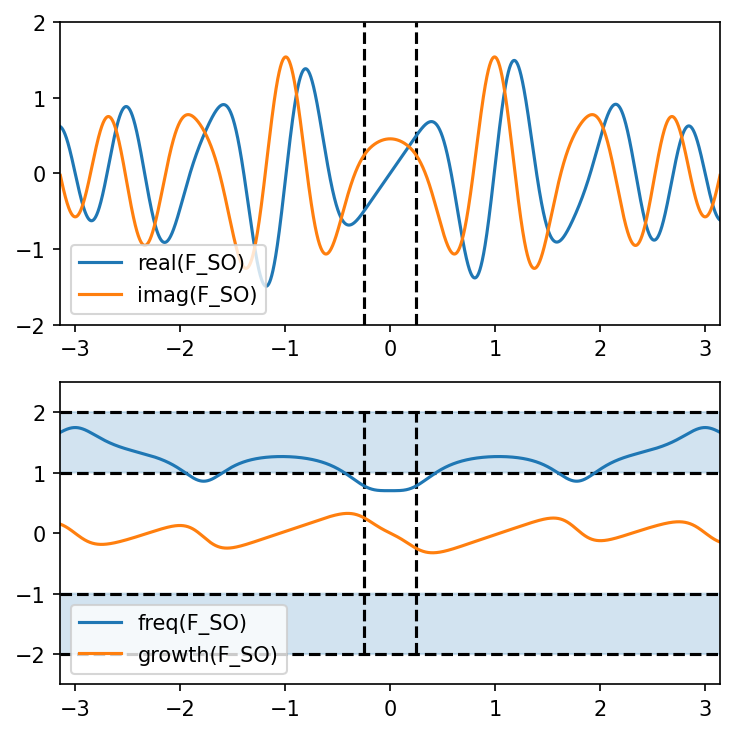

In [ ]:
r = t - 0.
sol = [ 0.65050157,
        0.48107457,
        -0.49920901,
        -0.10730917,
        -0.29207321,
        0.15058321,
        0.07248865]
F_SO = 0

for i in range(len(sol)):
    w = 2*np.pi*(1+i/(len(sol)-1))
    F_SO += (sol[i] * (np.sin(w*r) + 1j*np.cos(w*r)) )
s = .05

F_SO *= ((np.sin(s*r))/(s*r))**8

osc = np.diff(np.unwrap(np.angle(F_SO)))
growth = np.diff(np.abs(F_SO))/np.abs(F_SO)[:-1]

fig, (axs, axs2) = plt.subplots(2,1, figsize=(5,5), dpi=150)
axs.vlines((-.25, .25), -2, 2, colors='black', linestyles='dashed')
axs.plot(t, np.real(F_SO), label='real(F_SO)')
axs.plot(t, np.imag(F_SO), label='imag(F_SO)')
axs.legend(loc='lower left')
axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-2, 2)

axs2.fill_between(t, -2, -1, alpha=.2, color='tab:blue')
axs2.fill_between(t, 1, 2, alpha=.2, color='tab:blue')
axs2.vlines((-.25, .25), -2, 2, colors='black', linestyles='dashed')
axs2.hlines((-2, -1, 1, 2), -np.pi, np.pi, colors='black', linestyles='dashed')
axs2.plot(t[:-1], -invdt*osc/(2*np.pi), label='freq(F_SO)')
axs2.plot(t[:-1], -invdt*growth/(2*np.pi), label='growth(F_SO)')
axs2.legend(loc='lower left')
axs2.set_xlim(-np.pi, np.pi)
axs2.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

## how straight can we make the sub-oscillating region?

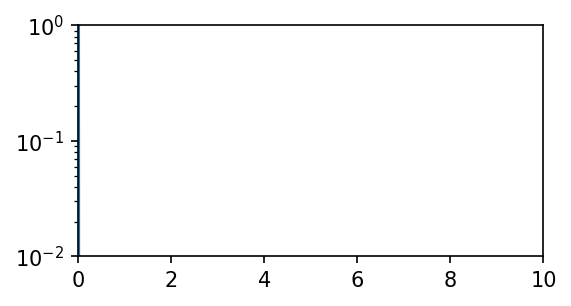

3.236350355443845e-16


In [ ]:
xwidth  = 1
res     = 10000
xlen    = int(res*xwidth)
x       = np.linspace(-xwidth/2, xwidth/2, xlen)
y       = np.ones(xlen)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,2)

f = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), d=1/res)
f /= np.sum(f)

plt.plot(freq, np.abs(f))
plt.yscale('log')
plt.xlim(0, 10)
plt.ylim(1e-2, 1e0)
plt.show()

print(np.std(np.abs(f)*freq))

In [ ]:
results = []    # N, Omega, omega_min, max amp, MSE
for N in np.arange(3, 101, 1):
    print('N =', N)
    minfreq = 1
    for freqspread in range(1, 6):
        cyclewidth = (N-1)/freqspread
        maxfreq = minfreq + freqspread

        A = get_fourier_fit(x, N, minfreq, maxfreq)
        coefs, _, _, _ = sp.linalg.lstsq(A, y)

        t_test  = np.linspace(-10, 10, 20000)
        y_test  = fourier_series(t_test, coefs, minfreq, maxfreq)
        y_test2 = fourier_series(x, coefs, minfreq, maxfreq)

        _max = max(np.abs(y_test))
        _mean = np.mean((np.real(y)-np.real(y_test2))**2)
        results.append([N, freqspread, minfreq, _max, _mean])

N = 3
N = 4
N = 5
N = 6
N = 7
N = 8
N = 9
N = 10
N = 11
N = 12
N = 13
N = 14
N = 15
N = 16
N = 17
N = 18
N = 19
N = 20
N = 21
N = 22
N = 23
N = 24
N = 25
N = 26
N = 27
N = 28
N = 29
N = 30
N = 31
N = 32
N = 33
N = 34
N = 35
N = 36
N = 37
N = 38
N = 39
N = 40
N = 41
N = 42
N = 43
N = 44
N = 45
N = 46
N = 47
N = 48
N = 49
N = 50
N = 51
N = 52
N = 53
N = 54
N = 55
N = 56
N = 57
N = 58
N = 59
N = 60
N = 61
N = 62
N = 63
N = 64
N = 65
N = 66
N = 67
N = 68
N = 69
N = 70
N = 71
N = 72
N = 73
N = 74
N = 75
N = 76
N = 77
N = 78
N = 79
N = 80
N = 81
N = 82
N = 83
N = 84
N = 85
N = 86
N = 87
N = 88
N = 89
N = 90
N = 91
N = 92
N = 93
N = 94
N = 95
N = 96
N = 97
N = 98
N = 99
N = 100


In [ ]:
mins = pd.DataFrame(results)
mins.columns = ['N', 'Omega', 'omega_min', 'amp', 'MSE']

mins.head()

N  Omega  omega_min       amp       MSE
0  3      1          1  8.261438  0.241097
1  3      2          1  0.000600  1.000000
2  3      3          1  0.423585  0.963229
3  3      4          1  0.000600  1.000000
4  3      5          1  0.246808  0.982629

In [ ]:
# for every unique N value, find the record with the minimum MSE and print it.
MSE_mins = mins.groupby('N').apply(lambda x: x.loc[x['MSE'].idxmin()])
amp_mins = mins.groupby('N').apply(lambda x: x.loc[x['amp'].idxmin()])

In [ ]:
for i in amp_mins.index:
    print([j for j in amp_mins.loc[i]])

[3.0, 2.0, 1.0, 0.000599700115395002, 0.999999940029985]
[4.0, 3.0, 1.0, 0.0007994403177479749, 0.9999999200559611]
[5.0, 4.0, 1.0, 0.000999100673672845, 0.999999900089919]
[6.0, 5.0, 1.0, 0.001198681226095006, 0.999999880131855]
[7.0, 5.0, 1.0, 11.234528516610032, 0.2950172288041258]
[8.0, 5.0, 1.0, 19.143284602600566, 0.0020003230844784724]
[9.0, 5.0, 1.0, 26.633089691308257, 7.441498072478953e-06]
[10.0, 5.0, 1.0, 38.94002691852286, 2.0424422256945453e-08]
[11.0, 5.0, 1.0, 58.67606969285164, 4.14230842598579e-11]
[12.0, 5.0, 1.0, 90.2318447682902, 6.264011334784821e-14]
[13.0, 5.0, 1.0, 140.8403241032597, 7.152916856590098e-17]
[14.0, 5.0, 1.0, 222.36330887586846, 6.252950679886872e-20]
[15.0, 5.0, 1.0, 354.28387471883445, 4.2422115685545245e-23]
[16.0, 4.0, 1.0, 547.8797364001108, 1.9085169639080124e-26]
[17.0, 4.0, 1.0, 786.3237522850886, 1.412543226734848e-26]
[18.0, 5.0, 1.0, 462.0413875654587, 9.420528406575486e-27]
[19.0, 5.0, 1.0, 341.2251607147594, 2.1974734386083768e-27]
[2

In [ ]:
for i in MSE_mins.index:
    print([j for j in MSE_mins.loc[i]])

[3.0, 1.0, 2.0, 3.534130980813848, 0.8032067148132622]
[4.0, 1.0, 2.0, 9.724931250319631, 0.7786460728858259]
[5.0, 1.0, 2.0, 710.7192744810217, 0.4852981406847579]
[6.0, 1.0, 2.0, 8342.201799738768, 0.010099018799829296]
[7.0, 1.0, 2.0, 43921.67071545728, 5.289722328575994e-05]
[8.0, 1.0, 2.0, 241475.4837919084, 1.686791506010396e-07]
[9.0, 1.0, 2.0, 1378899.270731838, 3.469026610796817e-10]
[10.0, 1.0, 2.0, 8093365.218364387, 4.786997040081185e-13]
[11.0, 1.0, 2.0, 48509491.77019858, 4.978642794428717e-16]
[12.0, 1.0, 2.0, 23847135.56363713, 4.838580790214514e-16]
[13.0, 2.0, 2.0, 4133643.339335314, 1.8805590415089285e-18]
[14.0, 2.0, 2.0, 1926414.00573054, 1.9903604245822037e-18]
[15.0, 3.0, 2.0, 1597246.6190768257, 8.370115584670432e-20]
[16.0, 3.0, 2.0, 721494.2523321699, 1.604137017074596e-20]
[17.0, 4.0, 2.0, 685118.5369405368, 8.254529359607014e-21]
[18.0, 5.0, 2.0, 375531.7801096331, 2.4676787852881445e-21]
[19.0, 6.0, 2.0, 194099.79616537882, 8.729638817312737e-22]
[20.0, 6.0

In [ ]:
N               = 60
minfreq         = 1
freqspread      = 5
maxfreq         = minfreq + freqspread

A               = get_fourier_fit(x, N, minfreq, maxfreq)
coefs, _, _, _  = sp.linalg.lstsq(A, y)

_t              = np.linspace(-100, 100, 200000)
_y              = fourier_series(_t, coefs, minfreq, maxfreq, make_complex=True)

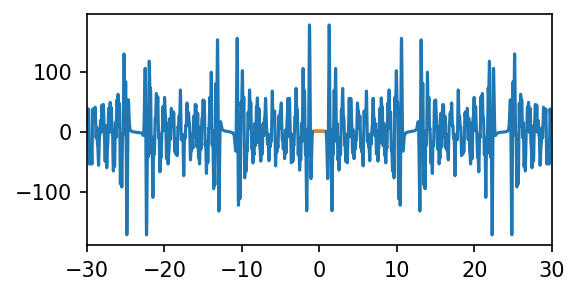

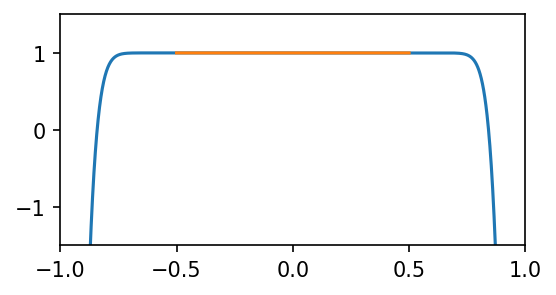

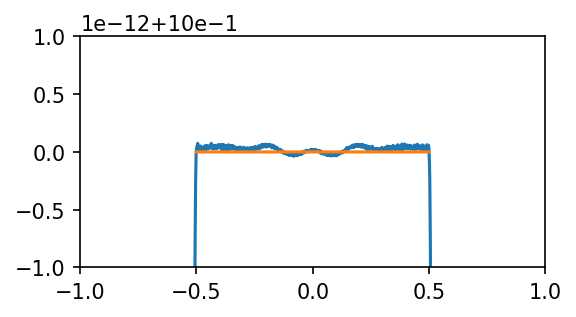

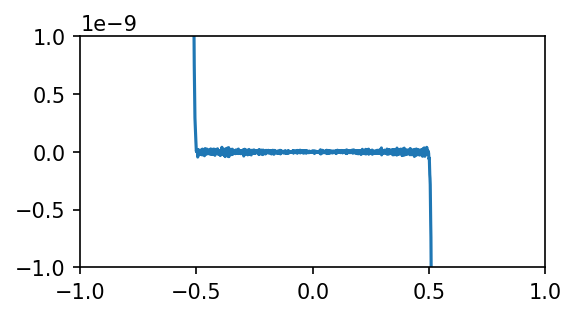

In [ ]:
plt.plot(_t, np.real(_y))
plt.plot(x, y)
plt.xlim(-30, 30)
plt.show()

plt.plot(_t, np.real(_y))
plt.plot(x, y)
plt.xlim(-1, 1)
plt.ylim(-1.5, 1.5)
plt.show()

plt.plot(_t, np.real(_y))
plt.plot(x, y)
plt.xlim(-1, 1)
plt.ylim(.999999999999, 1.000000000001)
plt.show()

plt.plot(_t[:-1], np.real(np.diff(_y)*1000))
# plt.vlines((-.5, .5), -1, 3, colors='black', linestyles='dashed')
plt.xlim(-1, 1)
plt.ylim(-1e-9, 1e-9)
plt.show()

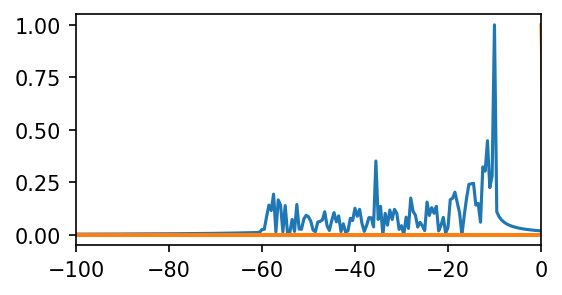

In [ ]:
f = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), d=1/res)

_f = np.fft.fft(_y)
_freq = np.fft.fftfreq(len(_y), d=1/res)

plt.plot(-_freq, np.abs(_f)/np.max(np.abs(_f)))
plt.plot(freq, np.abs(f)/np.max(np.abs(f)))
plt.xlim(-100, 0)
plt.show()

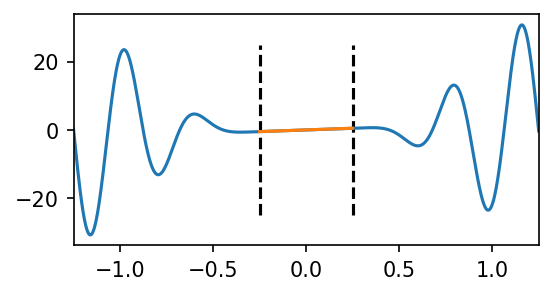

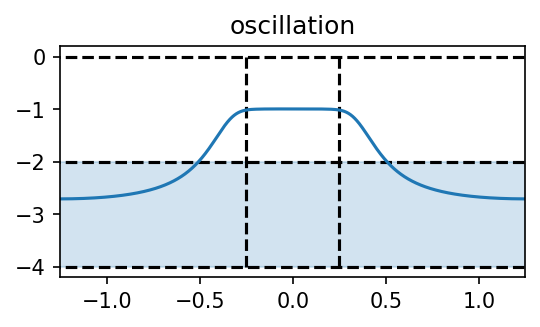

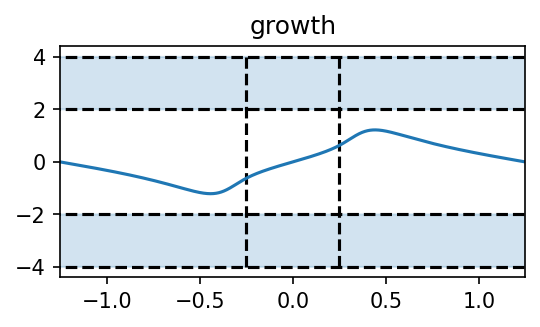

In [ ]:
growth_y = np.diff(np.abs(_y))/np.abs(_y)[:-1]*500/np.pi
growthy = np.diff(np.abs(y))/np.abs(y)[:-1]*500/np.pi
osc_y = np.diff(np.unwrap(np.angle(_y)))*500/np.pi
oscy = np.diff(np.unwrap(np.angle(y)))*500/np.pi

for i in range(len(growthy)):
    if growthy[i] < 0:
        growthy[i] = 0

plt.vlines((-.25, .25), -25, 25, colors='black', linestyles='dashed')
plt.plot(_t, np.real(_y))
plt.plot(x, y)
plt.xlim(-1.25, 1.25)
plt.show()

plt.title('oscillation')
plt.fill_between(_t, -4, -2, alpha=.2, color='tab:blue')
plt.hlines((-4, -2, 0), -2.5, 2.5, colors='black', linestyles='dashed')
plt.vlines((-.25, .25), -4, 0, colors='black', linestyles='dashed')
plt.plot(_t[:-1], osc_y)
plt.xlim(-1.25, 1.25)
plt.show()

plt.title('growth')
plt.fill_between(_t, -4, -2, alpha=.2, color='tab:blue')
plt.fill_between(_t, 2, 4, alpha=.2, color='tab:blue')
plt.hlines((-4, -2, 2, 4), -2.5, 2.5, colors='black', linestyles='dashed')
plt.vlines((-.25, .25), -4, 4, colors='black', linestyles='dashed')
plt.plot(_t[:-1], growth_y)
plt.xlim(-1.25, 1.25)
# plt.ylim(-1, 1)
plt.show()

 ## creating other types of superoscillations

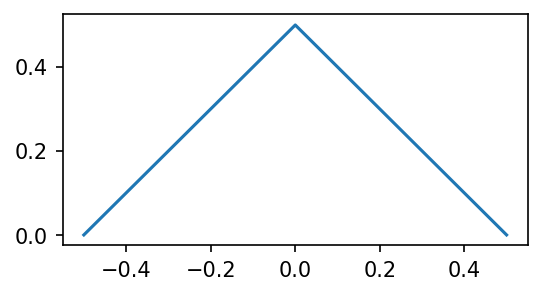

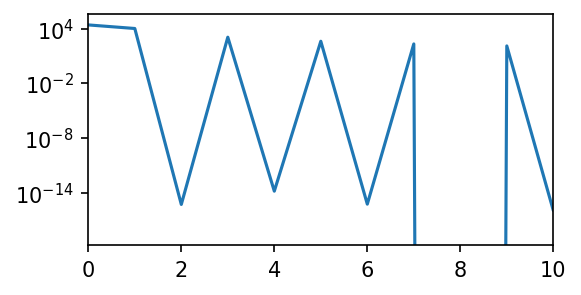

50.32931506166196


In [ ]:
length = 100000
width  = 1
x  = np.linspace(-width/2, width/2, 100000)
y  = .5-np.abs(x)
f  = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), d=width/length)

plt.plot(x, y)
plt.show()

plt.plot(freq, np.abs(f))
plt.xlim(0, 10)
plt.yscale('log')
# plt.ylim(1e-7, 1e4)
plt.show()

print(np.std(np.abs(f)*freq))

In [ ]:
# delete every record in both freq and f whose f value is less than .5
new_f       = []
new_freq    = []

for i in range(len(freq)):
    if np.abs(f[i]) > .5:
        new_f.append(f[i])
        new_freq.append(freq[i])

f2 = np.array(new_f) / np.sum(new_f)
freq2 = np.array(new_freq)

print(np.std(np.abs(f2)*freq2)*3)

56.27250349971446


In [ ]:
results = []    # N, Omega, omega_min, max amp, MSE
for N in np.arange(3, 21, 1):
    print('N =', N)
    minfreq = 0
    for freqspread in np.round(np.arange(.1, 3.1, .1), 2):
        cyclewidth = (N-1)/freqspread
        maxfreq = minfreq + freqspread

        A = get_fourier_fit(x, N, minfreq, maxfreq)
        coefs, _, _, _ = sp.linalg.lstsq(A, y)

        y_test2 = fourier_series(x, coefs, minfreq, maxfreq)

        _max = max(np.abs(y_test))
        _mean = np.mean((np.real(y)-np.real(y_test2))**2)
        results.append([N, freqspread, minfreq, _max, _mean])

N = 3
N = 4
N = 5
N = 6
N = 7
N = 8
N = 9
N = 10
N = 11
N = 12
N = 13
N = 14
N = 15
N = 16
N = 17
N = 18
N = 19
N = 20


In [ ]:
mins = pd.DataFrame(results)
mins.columns = ['N', 'Omega', 'omega_min', 'amp', 'MSE']

mins.head()

N  Omega  omega_min           amp       MSE
0  3    0.1          0  10667.413147  0.000325
1  3    0.2          0    646.009698  0.000322
2  3    0.3          0    120.929663  0.000317
3  3    0.4          0     35.397181  0.000311
4  3    0.5          0     13.053996  0.000304

In [ ]:
# for every unique N value, find the record with the minimum MSE and print it.
MSE_mins = mins.groupby('N').apply(lambda x: x.loc[x['MSE'].idxmin()])
amp_mins = mins.groupby('N').apply(lambda x: x.loc[x['amp'].idxmin()])

In [ ]:
for i in amp_mins.index:
    print([j for j in amp_mins.loc[i]])

[3.0, 1.0, 0.0, 0.4462738762998994, 0.00025072939652022566]
[4.0, 1.9, 0.0, 0.46334134428031126, 7.928150745150827e-05]
[5.0, 2.5, 0.0, 0.47097417020955107, 3.992859023544352e-05]
[6.0, 3.0, 0.0, 2.5157592429578486, 2.306034292482686e-05]
[7.0, 3.0, 0.0, 85.20568813089047, 1.618875580939668e-05]
[8.0, 3.0, 0.0, 4263.205245179435, 1.153741239336491e-05]
[9.0, 3.0, 0.0, 277831.5500210023, 8.419531471303622e-06]
[10.0, 3.0, 0.0, 23175215.375389516, 6.293637689109643e-06]
[11.0, 3.0, 0.0, 2420197616.690795, 4.81005298078676e-06]
[12.0, 2.6, 0.0, 9664368954.467592, 4.910469011858513e-06]
[13.0, 0.3, 0.0, 11147341357.131912, 3.486307916114989e-05]
[14.0, 0.3, 0.0, 10884770370.751963, 3.486218830721877e-05]
[15.0, 0.3, 0.0, 10704024321.30828, 3.486157004942534e-05]
[16.0, 0.3, 0.0, 10577923655.653076, 3.486112576781445e-05]
[17.0, 0.3, 0.0, 10489748990.524446, 3.486079605127108e-05]
[18.0, 0.3, 0.0, 10428232362.360893, 3.486059451820826e-05]
[19.0, 0.3, 0.0, 10386116983.578732, 3.486041432764

In [ ]:
for i in MSE_mins.index:
    print([j for j in MSE_mins.loc[i]])

[3.0, 1.6, 0.0, 0.4513946795859901, 0.00020465168462172425]
[4.0, 2.8, 0.0, 0.47204067744084743, 3.641021325684999e-05]
[5.0, 3.0, 0.0, 0.47279314991422744, 3.321308019186452e-05]
[6.0, 3.0, 0.0, 2.5157592429578486, 2.306034292482686e-05]
[7.0, 3.0, 0.0, 85.20568813089047, 1.618875580939668e-05]
[8.0, 3.0, 0.0, 4263.205245179435, 1.153741239336491e-05]
[9.0, 3.0, 0.0, 277831.5500210023, 8.419531471303622e-06]
[10.0, 3.0, 0.0, 23175215.375389516, 6.293637689109643e-06]
[11.0, 3.0, 0.0, 2420197616.690795, 4.81005298078676e-06]
[12.0, 3.0, 0.0, 310076937219.2282, 3.7558628130787114e-06]
[13.0, 3.0, 0.0, 58009269776.39878, 3.727943846661895e-06]
[14.0, 3.0, 0.0, 24678014880.963936, 3.711200935559624e-06]
[15.0, 3.0, 0.0, 3016563382668.455, 3.4562606433383227e-06]
[16.0, 3.0, 0.0, 1718623555191.8916, 3.0475226616108865e-06]
[17.0, 3.0, 0.0, 1123325495641.2236, 2.959345302288826e-06]
[18.0, 3.0, 0.0, 813741253602.6869, 2.948922338526569e-06]
[19.0, 3.0, 0.0, 623790792454.7153, 2.950043828138

In [ ]:
N               = 4
freqspread      = 3
minfreq         = 0
maxfreq         = minfreq + freqspread

A               = get_fourier_fit(x, N, minfreq, maxfreq)
coefs, _, _, _  = sp.linalg.lstsq(A, y)

_t              = np.linspace(-1000, 1000, 2000000)
_y              = fourier_series(_t, coefs, minfreq, maxfreq, make_complex=True)

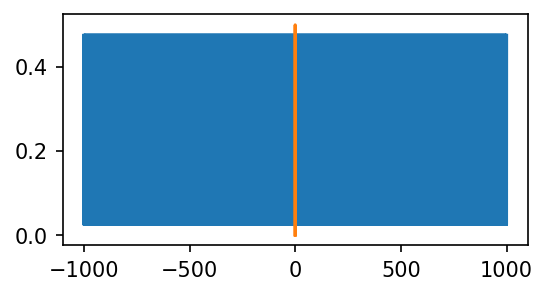

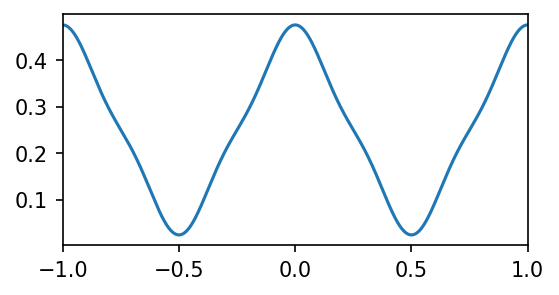

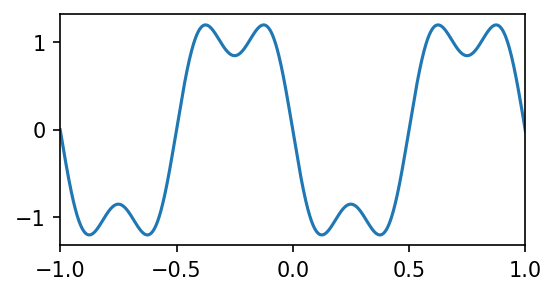

In [ ]:
plt.plot(_t, np.real(_y))
plt.plot(x, y)
# plt.xlim(-2, 2)
plt.show()

plt.plot(_t, np.real(_y))
# plt.plot(x, y)
plt.xlim(-1, 1)
plt.show()

plt.plot(_t[:-1], np.real(np.diff(_y)*1000))
# plt.vlines((-.5, .5), -1, 3, colors='black', linestyles='dashed')
plt.xlim(-1, 1)
# plt.ylim(-1e-9, 1e-9)
plt.show()

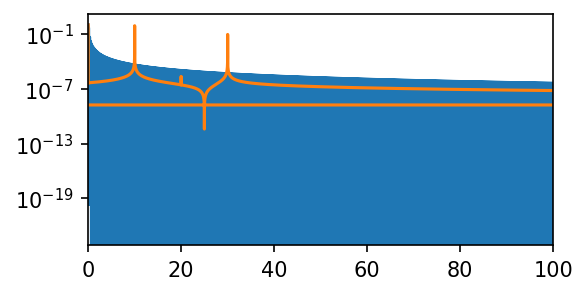

In [ ]:
f = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), d=1/res)

_f = np.fft.fft(_y)
_freq = np.fft.fftfreq(len(_y), d=1/res)

plt.plot(freq, np.abs(f)/np.max(np.abs(f)))
plt.plot(_freq, np.abs(_f)/np.max(np.abs(_f)))
plt.xlim(0, 100)
# plt.ylim(1e-4, 1e1)
plt.yscale('log')
plt.show()

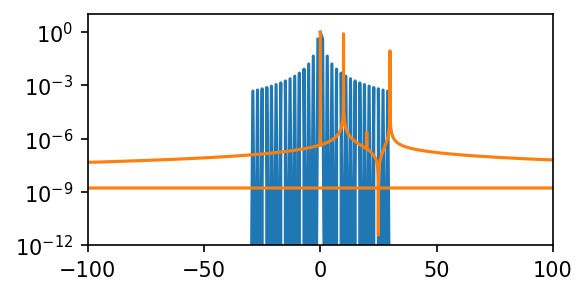

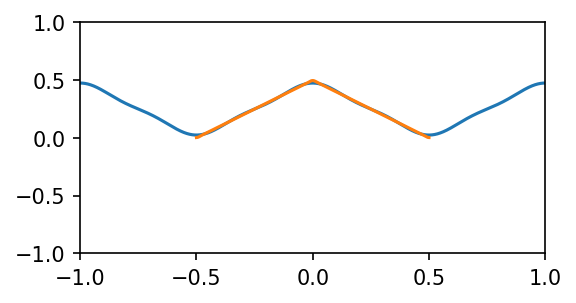

In [ ]:
f2 = np.copy(f)

for i in range(len(freq)):
    if np.abs(freq[i]) > 30:
        f2[i] = 0

plt.plot(freq, np.abs(f2)/np.max(np.abs(f2)))
plt.plot(_freq, np.abs(_f)/np.max(np.abs(_f)))
plt.xlim(-100, 100)
plt.ylim(1e-12, 1e1)
plt.yscale('log')
plt.show()

if2 = np.fft.ifft(f2)
plt.plot(_t, np.real(_y))
plt.plot(x, np.real(if2))
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.show()